# *santoshhulbutti@gmail.com | FlipRobo | Project #04

# Used Car price prediction - Regression model

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="darkgrid")

from sklearn.neighbors import KNeighborsRegressor


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

#For Regression model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

#For Evaluation metrics for regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import os

import pickle

import warnings
warnings.filterwarnings("ignore")

### Dataset loading

In [91]:
url = 'data/all_cars_data_fin.csv'
data0 = pd.read_csv(url)
data0

,Unnamed: 0,brand,model,variant,registration_year,km_driven,primary_fuel,transmission,registration_city,owner_comment,car_price,price_unit,color,owner_type,insurance_type,reg_type,engine_cap,cylinders,engine_type,max_power,max_p_rpm,max_torque,max_t_rpm,mileage,drive_type,turbocharger,car_length,car_segment,ground_clear
0,0,Maruti,Suzuki,Swift DZire LXI (O),Jun 2015,"55,000",Petrol,Manual,Noida,"Excellent condition,Well mentioned,Non acciden...",4.25,Lakh,Silver,First,Comprehensive,Individual,1197.0,4.0,K-Series Petrol engine with VVT,83.0,6000.0,115.0,4000.0,20.85,FWD,No,3995.0,A2,170.0
1,1,Renault,Kiger,RXZ AMT,Jun 2022,"1,080",Petrol,Automatic,Delhi,loan facilities available,9.1,Lakh,White,First,Comprehensive,Individual,999.0,3.0,1.0L Energy,71.0,6250.0,96.0,3500.0,19.03,FWD,No,3991.0,A2,205.0
2,2,Hyundai,Grand,i10 Sportz (O) 1.2 Kappa VTVT [2017-2018],May 2017,"35,018",Petrol,Manual,Delhi,"Immaculate Condition, Certified Car, Less Driv...",4.85,Lakh,Silver,First,"Comprehensive , till 19 Sep 2023",Individual,1197.0,4.0,1.2 Kappa Dual VTVT Petrol,81.0,6000.0,114.0,4000.0,19.77,FWD,No,3765.0,A2,165.0
3,3,Hyundai,Elite,i20 Magna 1.2 [2016-2017],Oct 2017,"45,876",Petrol,Manual,Delhi,"Immaculate Condition, Single Owner, Non Accide...",5.2,Lakh,Silver,First,"Comprehensive , till 23 Nov 2022",Individual,1197.0,4.0,"1.2 Kappa petrol with dual VTVT, 16 Valves, 4 ...",82.0,6000.0,115.0,4000.0,18.60,FWD,No,3985.0,A2,170.0
4,4,Honda,City,V,Aug 2015,"49,769",Petrol,Manual,Delhi,"Good Condition, Certified Car, Non Accidental,...",5.95,Lakh,White,First,"Comprehensive , till 13 Sep 2023",Individual,1497.0,4.0,NaN,117.0,6600.0,145.0,4600.0,17.80,FWD,No,4440.0,A3,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4055,4055,Hyundai,Xcent,S 1.2 Special Edition,Jun 2015,"74,232",Petrol,Manual,Nashik,"Good Condition, Certified Car, Less Driven, No...",4.9,Lakh,White,First,Not Available,Individual,1197.0,4.0,1.2 Kappa Dual VTVT Petrol,81.0,6000.0,114.0,4000.0,19.10,FWD,No,3995.0,A2,165.0
4056,4056,Skoda,Superb,Elegance TSI MT,Jun 2015,"69,270",Petrol,Manual,Nashik,"Excellent Condition, Certified Car, Less Drive...",9.5,Lakh,White,First,Not Available,Individual,1798.0,4.0,"Turbocharged petrol engine, in-line, liquid co...",158.0,4500.0,250.0,1500.0,13.70,FWD,Turbocharged,4833.0,A5,159.0
4057,4057,Hyundai,Grand,i10 Magna 1.2 Kappa VTVT [2013-2016],Jun 2014,"41,869",Petrol,Manual,Nashik,"Excellent Condition, Certified Car, Less Drive...",4.25,Lakh,Grey,First,Comprehensive,Individual,1197.0,4.0,1.2 Kappa Dual VTVT Petrol,81.0,6000.0,114.0,4000.0,18.90,FWD,No,3765.0,A2,165.0
4058,4058,Volkswagen,Vento,Highline Diesel,Jun 2014,"75,547",Diesel,Manual,Nashik,"Excellent Condition, Certified Car, Less Drive...",5.5,Lakh,Beige,First,Not Available,Individual,1598.0,4.0,4 cylinder inline,103.0,4400.0,250.0,1500.0,20.50,FWD,NaN,4384.0,A3,168.0


In [92]:
data0.duplicated().sum()

0

### dropping irrelevant columns

In [4]:
data1 = data0.copy()
data1.drop('Unnamed: 0', axis=1, inplace=True)

### Checking for missing value & imputation

In [5]:
#function to check unique values, missing entries & data type
def unique_null_data(data):
    xx = pd.DataFrame(list(zip(data.nunique(), data.isnull().sum(), data.dtypes)),
                                columns = ['unique_entries', 'missing values', 'Dtypes'],
                                index=data.columns)
    return xx

In [6]:
unique_null_data(data1)

,unique_entries,missing values,Dtypes
brand,33,1,object
model,200,1,object
variant,1361,1,object
registration_year,178,0,object
km_driven,2272,1,object
primary_fuel,16,0,object
transmission,2,1,object
registration_city,29,0,object
owner_comment,1237,679,object
car_price,1062,0,object


## Data Cleaning

In [7]:
#separating month Y year from registration year
data1['registration_month'] = ''
data1['registration_year2'] = 0
for i in range(len(data1['registration_year'])):
    data1['registration_month'].loc[i] = data1['registration_year'].loc[i].split(' ')[0]
    data1['registration_year2'].loc[i] = int(data1['registration_year'].loc[i].split(' ')[1])
    
    
    
    

#removing ',' from km_driven    
for i in range(len(data1['km_driven'])):
    try:
        data1['km_driven'].loc[i] = int(data1['km_driven'].loc[i].replace(',',''))
    except:
        pass
    try:
        data1['car_price'].loc[i] = float(data1['car_price'].loc[i].replace(',',''))
    except:
        pass

In [8]:
data1[data1['brand'].isnull()]

,brand,model,variant,registration_year,km_driven,primary_fuel,transmission,registration_city,owner_comment,car_price,price_unit,color,owner_type,insurance_type,reg_type,engine_cap,cylinders,engine_type,max_power,max_p_rpm,max_torque,max_t_rpm,mileage,drive_type,turbocharger,car_length,car_segment,ground_clear,registration_month,registration_year2
945,NaN,NaN,NaN,Jun 2019,NaN,"24,691",NaN,Petrol,"Good Condition, Certified Car, Non Accidental,...",3.75,Lakh,Silver,First,Comprehensive,Individual,799.0,3.0,i-SAT,53.0,5678.0,72.0,4386.0,22.7,FWD,No,3429.0,A2,185.0,Jun,2019


In [9]:
data1.drop(945, inplace = True)
data1.drop('registration_year', axis=1, inplace=True)

In [10]:
data1['km_driven'] = data1['km_driven'].astype('int')
data1['car_price'] = data1['car_price'].astype('float')

### Converting Thousand into lakhs in car_price feature 

In [11]:
data1[data1['price_unit'].isnull()].index

Int64Index([273, 1920, 1977, 2244, 3147, 3318, 3345], dtype='int64')

In [12]:
for ind in data1[data1['price_unit'].isnull()].index:
    data1['car_price'].loc[ind] = data1['car_price'].loc[ind]/100000.0

In [13]:
#dropping price_unit
data1.drop('price_unit', axis=1, inplace=True)

In [14]:
temp_01 = data1.groupby(['brand', 'model', 'variant'])[['engine_cap', 'cylinders']].mean()

In [15]:
temp_01.loc['Audi'].loc['A4']['engine_cap'].median()

1968.0

### Missing value imputation for 'engine_cap' & 'cylinders'.

In [16]:
data1[data1['engine_cap'].isnull()].index

Int64Index([   8,   20,   28,  122,  221,  419,  436,  460,  474,  502,
            ...
            3781, 3853, 3855, 3875, 3890, 3922, 3926, 3953, 3957, 4039],
           dtype='int64', length=126)

In [17]:
for ind in data1[data1['engine_cap'].isnull()].index:
    brnd = data1['brand'].loc[ind]
    mdl = data1['model'].loc[ind]
    data1['engine_cap'].loc[ind] = temp_01.loc[brnd].loc[mdl]['engine_cap'].median()
    
for ind in data1[data1['cylinders'].isnull()].index:
    brnd = data1['brand'].loc[ind]
    mdl = data1['model'].loc[ind]
    data1['cylinders'].loc[ind] = temp_01.loc[brnd].loc[mdl]['cylinders'].median()

In [18]:
for ind in data1[data1['engine_cap'].isnull()].index:
    brnd = data1['brand'].loc[ind]
    mdl = data1['model'].loc[ind]
    data1['engine_cap'].loc[ind] = temp_01.loc[brnd].loc[mdl]['engine_cap'].mean()
    
for ind in data1[data1['cylinders'].isnull()].index:
    brnd = data1['brand'].loc[ind]
    mdl = data1['model'].loc[ind]
    data1['cylinders'].loc[ind] = temp_01.loc[brnd].loc[mdl]['cylinders'].mean()

### Missing value imputation for 'drive_type', 'turbocharger', 'car_segment', 'max_power', 'max_p_rpm',  'max_torque', 'max_t_rpm', 'mileage', 'car_length', & 'ground_clear'

In [19]:
temp_02 = data1.groupby(['brand', 'model'])[['engine_type', 'drive_type', 'turbocharger', 'car_segment']].agg(pd.Series.mode)

In [20]:
temp_03 = data1.groupby(['brand', 'model'])[['max_power', 'max_p_rpm', 'max_torque','max_t_rpm','mileage','car_length','ground_clear']].median()

In [21]:
for column in ['max_power', 'max_p_rpm', 'max_torque','max_t_rpm','mileage','car_length','ground_clear']:
    for ind in data1[data1[column].isnull()].index:
        brnd = data1['brand'].loc[ind]
        mdl = data1['model'].loc[ind]
        data1[column].loc[ind] = temp_03.loc[brnd].loc[mdl][column]
        if column == 'car_length':
            car_length = temp_03.loc[brnd].loc[mdl][column]
            if car_length <= 3400:
                data1['car_segment'].loc[ind] = 'A1'
            elif car_length <= 4000:
                data1['car_segment'].loc[ind] = 'A2'
            elif car_length <= 4500:
                data1['car_segment'].loc[ind] = 'A3'
            elif car_length <= 4700:
                data1['car_segment'].loc[ind] = 'A4'
            elif car_length <= 5000:
                data1['car_segment'].loc[ind] = 'A5'
            elif car_length > 5000:
                data1['car_segment'].loc[ind] = 'A6'

In [22]:
temp_04 = data1.groupby(['brand'])[['max_power', 'max_p_rpm', 'max_torque','max_t_rpm','mileage','car_length','ground_clear']].mean()

In [23]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [24]:
for column in ['mileage','ground_clear']:
    temp_04 = knn_impute(temp_04, column)

In [25]:
for column in ['max_power', 'max_p_rpm', 'max_torque','max_t_rpm','mileage','car_length','ground_clear']:
    for ind in data1[data1[column].isnull()].index:
        brnd = data1['brand'].loc[ind]
        data1[column].loc[ind] = temp_04.loc[brnd][column]
        if column == 'car_length':
            car_length = temp_04.loc[brnd][column]
            if car_length <= 3400:
                data1['car_segment'].loc[ind] = 'A1'
            elif car_length <= 4000:
                data1['car_segment'].loc[ind] = 'A2'
            elif car_length <= 4500:
                data1['car_segment'].loc[ind] = 'A3'
            elif car_length <= 4700:
                data1['car_segment'].loc[ind] = 'A4'
            elif car_length <= 5000:
                data1['car_segment'].loc[ind] = 'A5'
            elif car_length > 5000:
                data1['car_segment'].loc[ind] = 'A6'

### Missing value imputation for 'drive_type' & 'turbocharger'.

In [26]:
temp_05 = data1.groupby(['brand', 'model', 'primary_fuel', 'transmission'])['drive_type', 'turbocharger'].agg(pd.Series.mode)

In [27]:
for column in ['drive_type', 'turbocharger']:
    for ind in data1[data1[column].isnull()].index:
        brnd = data1['brand'].loc[ind]
        mdl = data1['model'].loc[ind]
        fuel = data1['primary_fuel'].loc[ind]
        trans = data1['transmission'].loc[ind]
        if type(temp_05.loc[brnd].loc[mdl].loc[fuel].loc[trans][column]) == np.ndarray:
            if len(temp_05.loc[brnd].loc[mdl].loc[fuel].loc[trans][column]) == 0:
                data1[column].loc[ind] = data1[column].value_counts().index[0]
            elif len(temp_05.loc[brnd].loc[mdl].loc[fuel].loc[trans][column]) == 1:
                data1[column].loc[ind] = data1[column].value_counts().index[0]
            elif len(temp_05.loc[brnd].loc[mdl].loc[fuel].loc[trans][column]) > 1:
                data1[column].loc[ind] = temp_05.loc[brnd].loc[mdl].loc[fuel].loc[trans][column][0]
        else:
            data1[column].loc[ind] = temp_05.loc[brnd].loc[mdl].loc[fuel].loc[trans][column]

In [28]:
data1['turbocharger'].value_counts()

No                             2303
Turbocharged                   1652
Yes                              52
Twin Turbo                       49
Turbocharger + Supercharger       2
Not Applicable                    1
Name: turbocharger, dtype: int64

In [29]:
unique_null_data(data1)

,unique_entries,missing values,Dtypes
brand,33,0,object
model,200,0,object
variant,1361,0,object
km_driven,2272,0,int32
primary_fuel,15,0,object
transmission,2,0,object
registration_city,28,0,object
owner_comment,1236,679,object
car_price,1062,0,float64
color,101,0,object


In [30]:
data2 = data1.copy()

## Checking for data consistancy

In [31]:
data2.isin([' ','NA','-', None, np.nan, 0]).sum()

brand                   0
model                   0
variant                 0
km_driven               1
primary_fuel            0
transmission            0
registration_city       0
owner_comment         679
car_price               0
color                   0
owner_type              0
insurance_type          0
reg_type                0
engine_cap             18
cylinders              19
engine_type           523
max_power               0
max_p_rpm               0
max_torque              0
max_t_rpm               0
mileage                 0
drive_type              0
turbocharger            0
car_length              0
car_segment             0
ground_clear            0
registration_month      0
registration_year2      0
dtype: int64

In [32]:
data2[data2['km_driven'] == 0]

,brand,model,variant,km_driven,primary_fuel,transmission,registration_city,owner_comment,car_price,color,owner_type,insurance_type,reg_type,engine_cap,cylinders,engine_type,max_power,max_p_rpm,max_torque,max_t_rpm,mileage,drive_type,turbocharger,car_length,car_segment,ground_clear,registration_month,registration_year2
4030,Maruti,Suzuki,S-Cross Zeta 1.6,0,Diesel,Manual,Nashik,"Excellent Condition, Certified Car, Less Drive...",7.5,White,First,Comprehensive,Individual,1598.0,4.0,DDiS 320,118.0,3750.0,320.0,1750.0,22.07,FWD,Turbocharged,4300.0,A3,180.0,Jun,2016


In [33]:
data2_1 = data2.drop(4030, axis = 0)

In [34]:
temp_06 = data2_1.groupby(['brand', 'model'])['km_driven', 'car_price'].median()
temp_06

km_driven  car_price
brand model                       
Aston Martin     2600.0      2.180
Audi  A3        47560.0     21.900
      A4        50000.0     24.700
      A5        32000.0     43.500
      A6        56275.0     21.500
...                 ...        ...
Volvo V40       44000.0     17.350
      V90       30335.5     48.750
      XC40      30600.0     34.000
      XC60      66403.5     22.375
      XC90      59000.0     49.000

[200 rows x 2 columns]

In [35]:
data2['km_driven'].loc[4030] = temp_06.loc['Maruti'].loc['Suzuki']['km_driven']

In [36]:
data2.isin([' ','NA','-', None, np.nan, 0]).sum()

brand                   0
model                   0
variant                 0
km_driven               0
primary_fuel            0
transmission            0
registration_city       0
owner_comment         679
car_price               0
color                   0
owner_type              0
insurance_type          0
reg_type                0
engine_cap             18
cylinders              19
engine_type           523
max_power               0
max_p_rpm               0
max_torque              0
max_t_rpm               0
mileage                 0
drive_type              0
turbocharger            0
car_length              0
car_segment             0
ground_clear            0
registration_month      0
registration_year2      0
dtype: int64

In [37]:
for ind in data2[data2['brand'] =='Maruti'].index:
    try:
        data2['model'].loc[ind] = data2['variant'].loc[ind].split(' ')[0] +' '+ data2['variant'].loc[ind].split(' ')[1]
    except:
        pass

In [38]:
for ind in data2[data2['brand'] =='Hyundai'].index:
    mdl = data2['model'].loc[ind]
    if ((mdl == 'Grand') | (mdl == 'Elite')):
        data2['model'].loc[ind] = data2['model'].loc[ind] + ' ' + data2['variant'].loc[ind].split(' ')[0]

In [39]:
for ind in data2[data2['model'] =='i10'].index:
    data2['model'].loc[ind] = 'Grand i10'

In [40]:
data2.drop(columns = ['variant','owner_comment', 'engine_type', 'car_length'], inplace=True)

In [41]:
data2.dropna(inplace=True)

In [42]:
data2.isin([' ','NA','-', None, np.nan, 0]).sum()

brand                 0
model                 0
km_driven             0
primary_fuel          0
transmission          0
registration_city     0
car_price             0
color                 0
owner_type            0
insurance_type        0
reg_type              0
engine_cap            0
cylinders             0
max_power             0
max_p_rpm             0
max_torque            0
max_t_rpm             0
mileage               0
drive_type            0
turbocharger          0
car_segment           0
ground_clear          0
registration_month    0
registration_year2    0
dtype: int64

In [43]:
cat_cols = data2.select_dtypes(object).columns
num_cols = data2.select_dtypes(np.number).columns

In [44]:
print(len(cat_cols))
print(len(num_cols))

13
11


In [45]:
data2['turbocharger'] = data2['turbocharger'].replace(['Turbocharged', 'Yes', 'Twin Turbo', 'Turbocharger + Supercharger'], 1)
data2['turbocharger'] = data2['turbocharger'].replace(['No', 'Not Applicable'], 0)

In [46]:
data2['reg_type'] = data2['reg_type'].replace(['Taxi', 'Not Available'], 'Others')

In [47]:
for ind in data2['insurance_type'].index:
    text = data2['insurance_type'].loc[ind]
    try:
        data2['insurance_type'].loc[ind] = text.split(' , ')[0]
    except:
        pass

In [48]:
data2['insurance_type'] = data2['insurance_type'].replace(['Third Party', 'ThirdParty'], '3rd Party')
data2['insurance_type'] = data2['insurance_type'].replace(['Not Available', 'Expired'], 'No')

In [49]:
data2['owner_type'].value_counts().index

Index(['First', 'Second', 'Third', '4 or More', 'UnRegistered Car', 'Fourth'], dtype='object')

In [50]:
data2['owner_type'] = data2['owner_type'].replace(['4 or More', 'UnRegistered Car', 'Fourth'], 'Fourth or Other')

In [51]:
colors = ['Silver', 'White', 'Grey', 'Brown', 'Maroon', 'Red', 'Black', 'Blue', 'Bronze', 'Beige', 'Yellow', 'Green', 'Gold', 'Orange', 'Purple', 'Pink', 'Saloon', 'Begie']

In [52]:
for ind in data2['color'].index:
    try:
        clrs = data2['color'].loc[ind].split(' ')
        for cl in clrs:
            if cl in colors:
                data2['color'].loc[ind] = cl
    except:
        pass

In [53]:
data2['primary_fuel'] = data2['primary_fuel'].replace('Petrol + Petrol','Petrol')
data2['primary_fuel'] = data2['primary_fuel'].replace('Diesel + Diesel', 'Diesel')
data2['primary_fuel'] = data2['primary_fuel'].replace(['Petrol + Diesel', 'Diesel + Petrol'], 'Petrol + Diesel')
data2['primary_fuel'] = data2['primary_fuel'].replace('Mild Hybrid(Electric + Petrol)', 'Hybrid')

In [54]:
# data2['registration_month'].value_counts().index
month_dict = {'Jun':6,'Jan':1,'May':5,'Mar':3,'Feb':2,'Oct':10,'Sep':9,'Aug':8,'Jul':7,'Apr':4,'Nov':11,'Dec':12}
data2['registration_month'] = data2['registration_month'].map(month_dict)

In [55]:
data2['registration_month'] = (-np.cos(0.5236 * data2['registration_month']))

In [56]:
data3 = data2.copy()

In [57]:
data3.to_csv('data/all_cars_data_edafinal.csv')

## Data Visualization

### categorical columns
'brand', 'model', 'primary_fuel', 'transmission', 'registration_city', 'color', 'owner_type', 'insurance_type', 'reg_type', 'drive_type','car_segment'


### Numerical columns
'km_driven', 'car_price', 'engine_cap', 'cylinders', 'max_power', 'max_p_rpm', 'max_torque', 'max_t_rpm', 'mileage', 'turbocharger', 'ground_clear', 'registration_month', 'registration_year2'

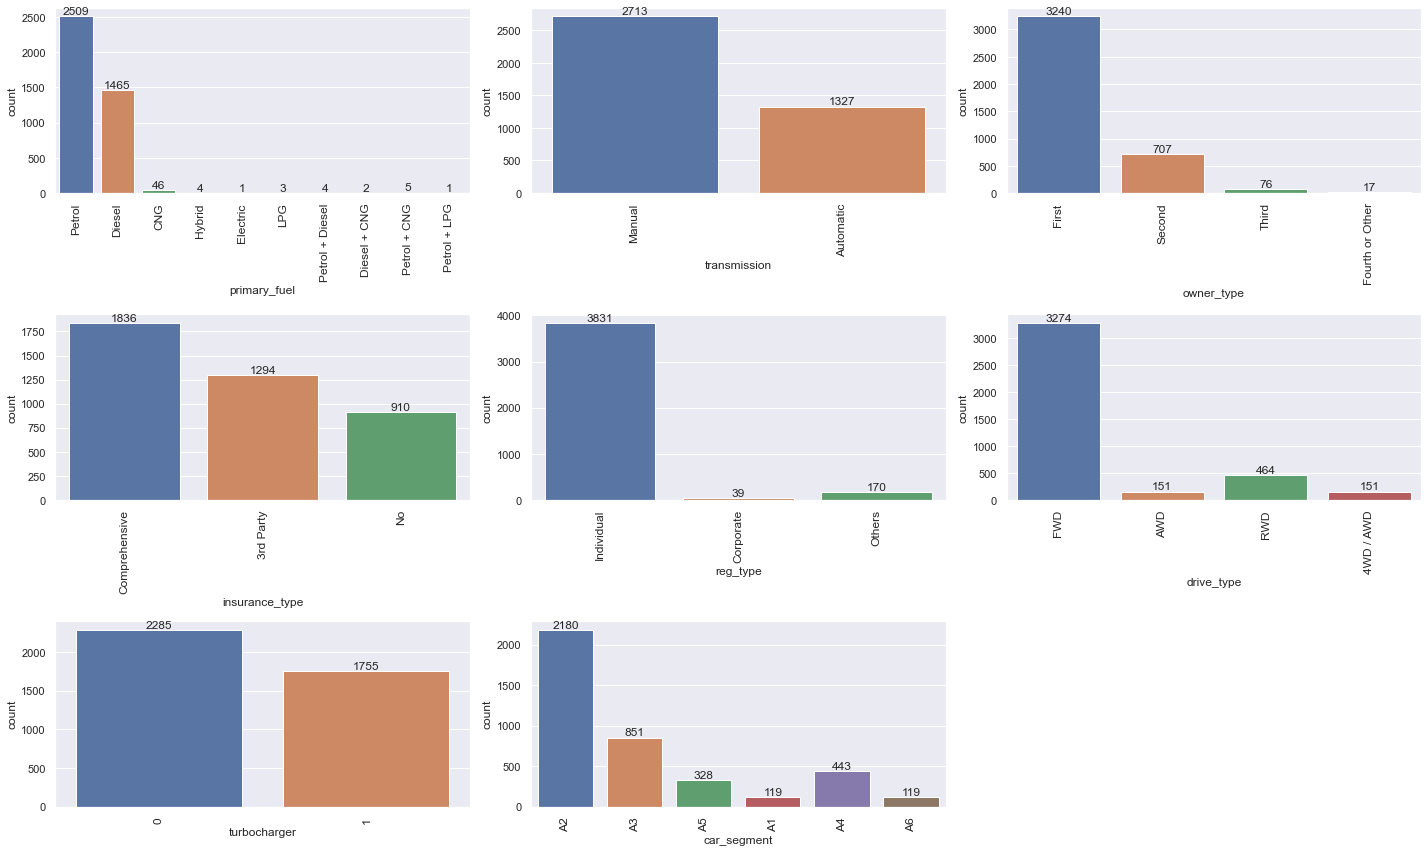

In [58]:
#distribution of discrete numerical features using countplot
i=0
plt.figure(figsize=(20,12))
for column in ['primary_fuel', 'transmission', 'owner_type', 'insurance_type', 'reg_type', 'drive_type',
       'turbocharger', 'car_segment']:
    plt.subplot(3,3,i+1)
    ax = sns.countplot(x= data3[column])
    ax.bar_label(ax.containers[0]);
    plt.xticks(fontsize = 12, rotation=90)
    plt.xlabel(column,fontsize=12)
    i+=1
    
plt.tight_layout()

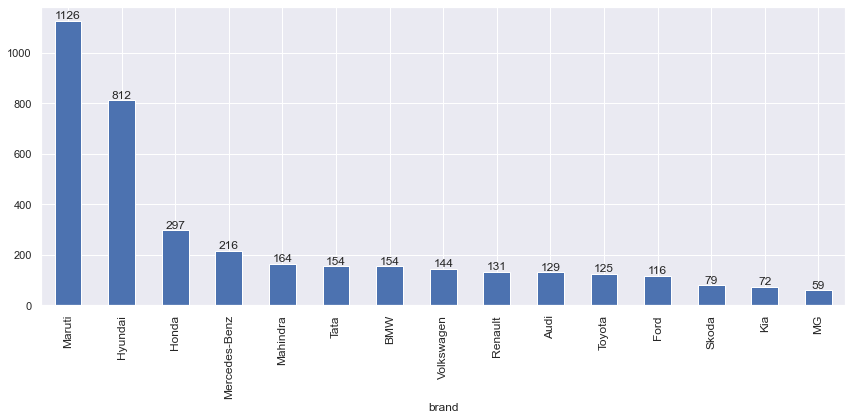

In [59]:
plt.figure(figsize=(12,6))
ax = data3['brand'].value_counts(ascending = False)[:15].plot(kind="bar")
# ax = sns.countplot(x= data3['brand'])
ax.bar_label(ax.containers[0]);
plt.xticks(fontsize = 12, rotation=90)
plt.xlabel('brand',fontsize=12)
plt.tight_layout()

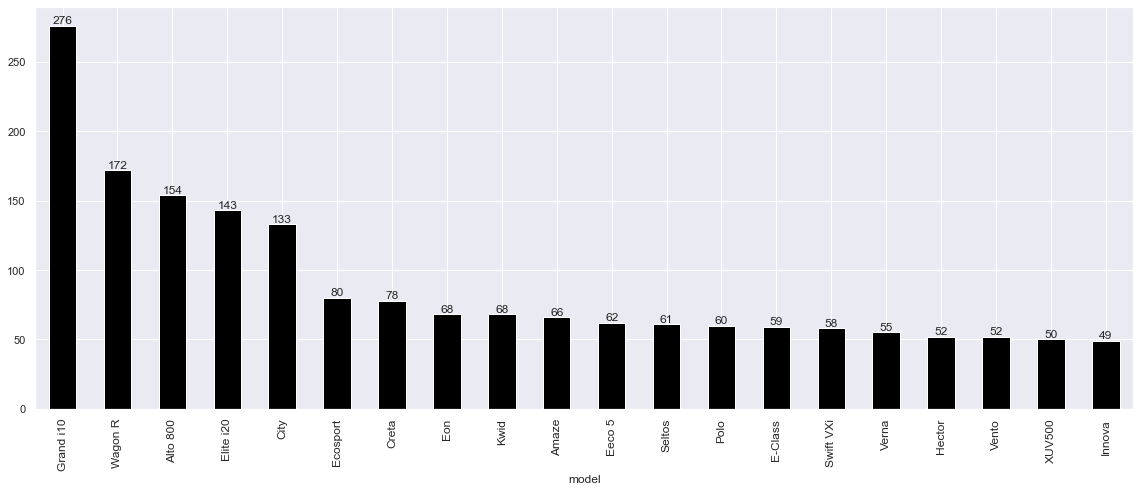

In [98]:
plt.figure(figsize=(16,7))
ax = data3['model'].value_counts(ascending = False)[:20].plot(kind="bar", colormap='CMRmap')
ax.bar_label(ax.containers[0]);
plt.xticks(fontsize = 12, rotation=90)
plt.xlabel('model',fontsize=12)
plt.tight_layout()

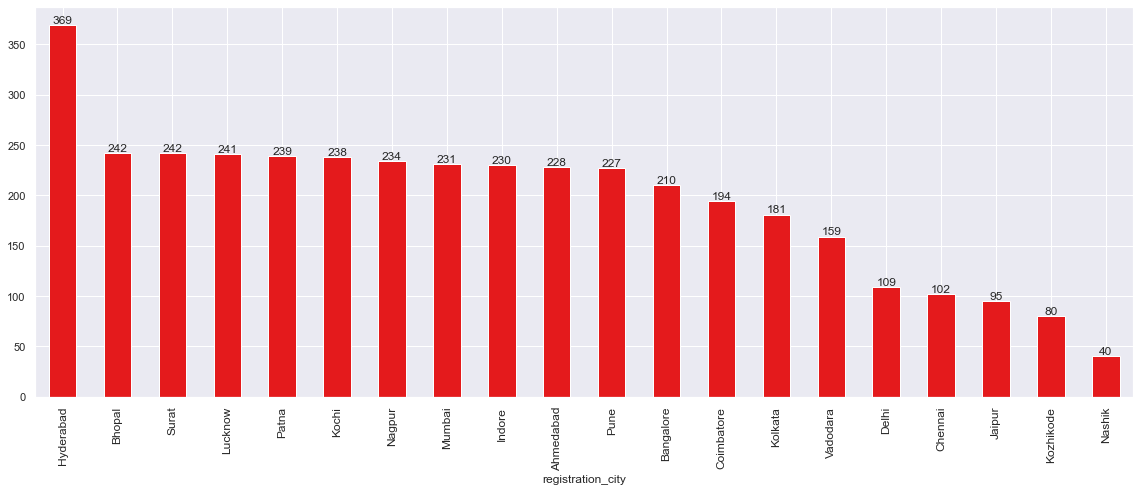

In [96]:
plt.figure(figsize=(16,7))
ax = data3['registration_city'].value_counts(ascending = False)[:20].plot(kind="bar", colormap = 'Set1')
ax.bar_label(ax.containers[0]);
plt.xticks(fontsize = 12, rotation=90)
plt.xlabel('registration_city',fontsize=12)
plt.tight_layout()

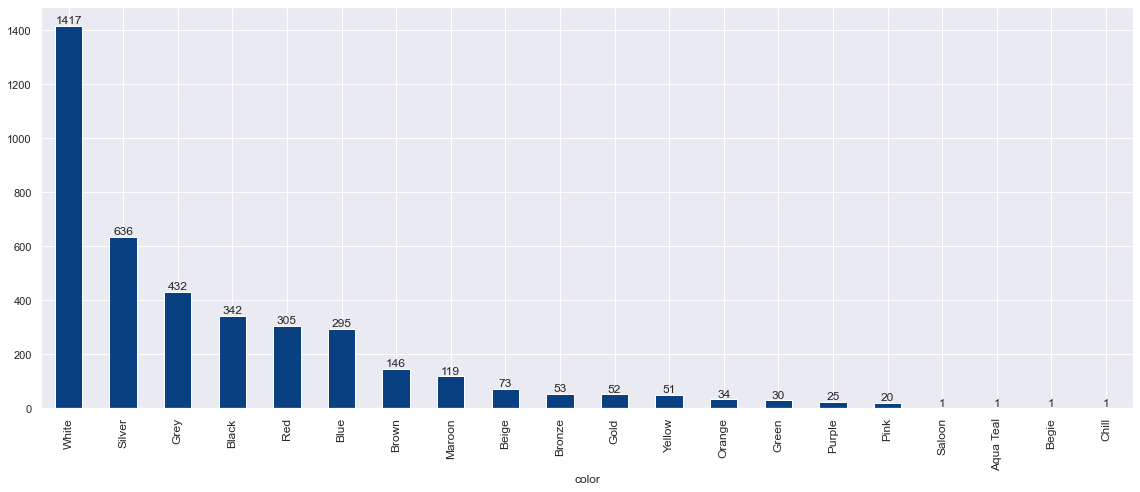

In [100]:
plt.figure(figsize=(16,7))
ax = data3['color'].value_counts(ascending = False)[:20].plot(kind="bar", colormap = 'GnBu_r')
ax.bar_label(ax.containers[0]);
plt.xticks(fontsize = 12, rotation=90)
plt.xlabel('color',fontsize=12)
plt.tight_layout()

In [61]:
cat_cols = data3.select_dtypes(object).columns
num_cols = data3.select_dtypes(np.number).columns

In [62]:
print(len(cat_cols))
print(len(num_cols))

11
13


In [63]:
data3.select_dtypes(object)

,brand,model,primary_fuel,transmission,registration_city,color,owner_type,insurance_type,reg_type,drive_type,car_segment
0,Maruti,Swift DZire,Petrol,Manual,Noida,Silver,First,Comprehensive,Individual,FWD,A2
1,Renault,Kiger,Petrol,Automatic,Delhi,White,First,Comprehensive,Individual,FWD,A2
2,Hyundai,Grand i10,Petrol,Manual,Delhi,Silver,First,Comprehensive,Individual,FWD,A2
3,Hyundai,Elite i20,Petrol,Manual,Delhi,Silver,First,Comprehensive,Individual,FWD,A2
4,Honda,City,Petrol,Manual,Delhi,White,First,Comprehensive,Individual,FWD,A3
...,...,...,...,...,...,...,...,...,...,...,...
4055,Hyundai,Xcent,Petrol,Manual,Nashik,White,First,No,Individual,FWD,A2
4056,Skoda,Superb,Petrol,Manual,Nashik,White,First,No,Individual,FWD,A5
4057,Hyundai,Grand i10,Petrol,Manual,Nashik,Grey,First,Comprehensive,Individual,FWD,A2
4058,Volkswagen,Vento,Diesel,Manual,Nashik,Beige,First,No,Individual,FWD,A3


In [64]:
data4 = data3.copy()

## Encoding Categorical features

In [65]:
data4 = pd.get_dummies(data4)

In [66]:
data4

,km_driven,car_price,engine_cap,cylinders,max_power,max_p_rpm,max_torque,max_t_rpm,mileage,turbocharger,ground_clear,registration_month,registration_year2,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Chevrolet,brand_Datsun,brand_Dehat,brand_Fiat,brand_Ford,brand_Honda,brand_Hyundai,brand_Isuzu,brand_Jaguar,brand_Jeep,brand_Kia,brand_Lamborghini,brand_Land,brand_Lexus,brand_MG,brand_MINI,brand_Mahindra,brand_Maruti,brand_Mercedes-Benz,brand_Mitsubishi,brand_Nissan,brand_Porsche,brand_Renault,brand_Skoda,brand_Ssangyong,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo,model_1-Series,model_1000 AC,model_2,model_3-Series,model_5-Series,model_6-Series,model_7-Series,model_718,model_800 AC,model_800 EX,model_800 Std,model_A-Class,model_A-Star Vxi,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_AMG,model_Accent,model_Accord,model_Alcazar,model_Alto 800,model_Alto LX,model_Alto LXi,model_Alto VXI,model_Alto VXi,model_Altroz,model_Alturas,model_Amaze,model_Ameo,model_Aspire,model_Astor,model_Aura,model_Aveo,model_B-class,model_BR-V,model_Baleno Alpha,model_Baleno Delta,model_Baleno RS,model_Baleno Sigma,model_Baleno Zeta,model_Beat,model_Beetle,model_Bolero,model_Boxster,model_Brio,model_C-Class,model_CLA,model_CR-V,model_Camry,model_Carnival,model_Cayenne,model_Celerio LXi,model_Celerio VXi,model_Celerio X,model_Celerio ZXi,model_Cherokee,model_Chevrolet,model_Ciaz Alpha,model_Ciaz Delta,model_Ciaz S,model_Ciaz Sigma,model_Ciaz VDi,model_Ciaz VDi+,model_Ciaz VXi,model_Ciaz VXi+,model_Ciaz ZDi,model_Ciaz ZDi+,model_Ciaz ZXI+,model_Ciaz ZXi,model_Ciaz Zeta,model_City,model_Civic,model_Clubman,model_Compass,model_Continental,model_Convertible,model_Cooper,model_Corolla,model_Countryman,model_Creta,model_Cruze,model_D-Max,model_DZire LXi,model_DZire VDi,model_DZire VXi,model_DZire ZDi,model_DZire ZXi,model_Duster,model_E-Class,model_ES,model_Ecosport,model_Eeco 5,model_Eeco 7,model_Elantra,model_Elite i20,model_Endeavour,model_Enjoy,model_Eon,model_Ertiga VDI,model_Ertiga VDi,model_Ertiga VXI,model_Ertiga VXi,model_Ertiga Vxi,model_Ertiga ZDI,model_Ertiga ZDi,model_Ertiga ZXI+,model_Ertiga ZXi,model_Estilo LXi,model_Etios,model_F-Pace,model_Fabia,model_Fiesta,model_Fiesta/Classic,model_Figo,model_Fluence,model_Ford,model_Fortuner,model_Freestyle,model_G-Class,model_GL-Class,model_GLA,model_GLC,model_GLE,model_GLS,model_Getz,model_Glanza,model_Gloster,model_Go,model_Grand i10,model_Gypsy King,model_Harrier,model_Hector,model_Hexa,model_Huracan,model_Hyundai,model_Ignis Alpha,model_Ignis Delta,model_Ignis Sigma,model_Ignis Zeta,model_Indica,model_Indigo,model_Innova,model_Jazz,model_Jetta,model_KUV100,model_Kicks,model_Kiger,model_Kushaq,model_Kwid,model_Laura,model_Linea,model_Lodgy,model_M-Class,model_Macan,model_Mahindra,model_Marazzo,model_Martin,model_Maruti,model_Maybach,model_Micra,model_Mobilio,model_Nano,model_Nexon,model_Octavia,model_Omni LPG,model_Optra,model_Pajero,model_Passat,model_Polo,model_Pulse,model_Punch,model_Punto,model_Q3,model_Q5,model_Q7,model_Q8,model_Quanto,model_Rapid,model_Redigo,model_Renault,model_Rexton,model_Ritz Ldi,model_Ritz Vdi,model_Ritz Vxi,model_Ritz Zdi,model_Ritz Zxi,model_Rover,model_S-Class,model_S-Cross Alpha,model_S-Cross Delta,model_S-Cross Sigma,model_S-Cross Zeta,model_S-Presso VXi,model_S5,model_S60,model_S90,model_SLC,model_SLK-Class,model_SX4 ZXi,model_Safari,model_Sail,model_Santa,model_Santro,model_Scorpio,model_Seltos,model_Sonata,model_Sonet,model_Spark,model_Sunny,model_Superb,model_Swift DZire,model_Swift Deca,model_Swift LDi,model_Swift LXi,model_Swift Lxi,model_Swift VDi,model_Swift VXi,model_Swift ZDi,model_Swift ZXi,model_TT,model_TUV300,model_Taigun,model_Tata,model_Tavera,model_Terrano,model_Thar,model_Tiago,model_Tigor,model_Tiguan,model_Triber,model_Tucson,model_Urban,model_V-Class,model_V40,model_V90,model_Vento,model_Venue,model_Verna,model_Versa DX,model_Vitara Brezza,model_Volkswagen,model_WR-V,model_Wagon R,model_X1,model_X3,model_X4,model_X5,mod

In [67]:
data4[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
km_driven,4040.0,582115.341337,3.378549e+07,75.00,25000.000000,44000.0,67345.00,2.147484e+09
car_price,4040.0,11.616054,1.343408e+01,0.80,4.310000,6.5,12.63,9.700000e+01
engine_cap,4040.0,1493.605322,5.732152e+02,624.00,1197.000000,1248.0,1950.00,5.998000e+03
cylinders,4040.0,3.870050,7.115181e-01,2.00,4.000000,4.0,4.00,1.200000e+01
max_power,4040.0,112.519747,5.902165e+01,37.00,74.000000,89.0,138.00,6.160000e+02
max_p_rpm,4040.0,5161.014017,1.049954e+03,2910.00,4000.000000,5600.0,6000.00,8.250000e+03
max_torque,4040.0,201.984264,1.309130e+02,51.00,113.000000,145.0,265.00,8.000000e+02
max_t_rpm,4040.0,2952.865440,1.190562e+03,1200.00,1750.000000,3500.0,4000.00,6.500000e+03
mileage,4040.0,18.734778,3.851641e+00,5.88,16.200000,18.9,21.21,3.354000e+01
turbocharger,4040.0,0.434406,4.957401e-01,0.00,0.000000,0.0,1.00,1.000000e+00


### Removing some unrealistic values

In [68]:
index_to_drop = data4[data4[num_cols]['km_driven']>300000].index

In [69]:
data4.drop(index_to_drop, inplace = True)

In [70]:
data4[data4[num_cols]['km_driven']<1000]

,km_driven,car_price,engine_cap,cylinders,max_power,max_p_rpm,max_torque,max_t_rpm,mileage,turbocharger,ground_clear,registration_month,registration_year2,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Chevrolet,brand_Datsun,brand_Dehat,brand_Fiat,brand_Ford,brand_Honda,brand_Hyundai,brand_Isuzu,brand_Jaguar,brand_Jeep,brand_Kia,brand_Lamborghini,brand_Land,brand_Lexus,brand_MG,brand_MINI,brand_Mahindra,brand_Maruti,brand_Mercedes-Benz,brand_Mitsubishi,brand_Nissan,brand_Porsche,brand_Renault,brand_Skoda,brand_Ssangyong,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo,model_1-Series,model_1000 AC,model_2,model_3-Series,model_5-Series,model_6-Series,model_7-Series,model_718,model_800 AC,model_800 EX,model_800 Std,model_A-Class,model_A-Star Vxi,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_AMG,model_Accent,model_Accord,model_Alcazar,model_Alto 800,model_Alto LX,model_Alto LXi,model_Alto VXI,model_Alto VXi,model_Altroz,model_Alturas,model_Amaze,model_Ameo,model_Aspire,model_Astor,model_Aura,model_Aveo,model_B-class,model_BR-V,model_Baleno Alpha,model_Baleno Delta,model_Baleno RS,model_Baleno Sigma,model_Baleno Zeta,model_Beat,model_Beetle,model_Bolero,model_Boxster,model_Brio,model_C-Class,model_CLA,model_CR-V,model_Camry,model_Carnival,model_Cayenne,model_Celerio LXi,model_Celerio VXi,model_Celerio X,model_Celerio ZXi,model_Cherokee,model_Chevrolet,model_Ciaz Alpha,model_Ciaz Delta,model_Ciaz S,model_Ciaz Sigma,model_Ciaz VDi,model_Ciaz VDi+,model_Ciaz VXi,model_Ciaz VXi+,model_Ciaz ZDi,model_Ciaz ZDi+,model_Ciaz ZXI+,model_Ciaz ZXi,model_Ciaz Zeta,model_City,model_Civic,model_Clubman,model_Compass,model_Continental,model_Convertible,model_Cooper,model_Corolla,model_Countryman,model_Creta,model_Cruze,model_D-Max,model_DZire LXi,model_DZire VDi,model_DZire VXi,model_DZire ZDi,model_DZire ZXi,model_Duster,model_E-Class,model_ES,model_Ecosport,model_Eeco 5,model_Eeco 7,model_Elantra,model_Elite i20,model_Endeavour,model_Enjoy,model_Eon,model_Ertiga VDI,model_Ertiga VDi,model_Ertiga VXI,model_Ertiga VXi,model_Ertiga Vxi,model_Ertiga ZDI,model_Ertiga ZDi,model_Ertiga ZXI+,model_Ertiga ZXi,model_Estilo LXi,model_Etios,model_F-Pace,model_Fabia,model_Fiesta,model_Fiesta/Classic,model_Figo,model_Fluence,model_Ford,model_Fortuner,model_Freestyle,model_G-Class,model_GL-Class,model_GLA,model_GLC,model_GLE,model_GLS,model_Getz,model_Glanza,model_Gloster,model_Go,model_Grand i10,model_Gypsy King,model_Harrier,model_Hector,model_Hexa,model_Huracan,model_Hyundai,model_Ignis Alpha,model_Ignis Delta,model_Ignis Sigma,model_Ignis Zeta,model_Indica,model_Indigo,model_Innova,model_Jazz,model_Jetta,model_KUV100,model_Kicks,model_Kiger,model_Kushaq,model_Kwid,model_Laura,model_Linea,model_Lodgy,model_M-Class,model_Macan,model_Mahindra,model_Marazzo,model_Martin,model_Maruti,model_Maybach,model_Micra,model_Mobilio,model_Nano,model_Nexon,model_Octavia,model_Omni LPG,model_Optra,model_Pajero,model_Passat,model_Polo,model_Pulse,model_Punch,model_Punto,model_Q3,model_Q5,model_Q7,model_Q8,model_Quanto,model_Rapid,model_Redigo,model_Renault,model_Rexton,model_Ritz Ldi,model_Ritz Vdi,model_Ritz Vxi,model_Ritz Zdi,model_Ritz Zxi,model_Rover,model_S-Class,model_S-Cross Alpha,model_S-Cross Delta,model_S-Cross Sigma,model_S-Cross Zeta,model_S-Presso VXi,model_S5,model_S60,model_S90,model_SLC,model_SLK-Class,model_SX4 ZXi,model_Safari,model_Sail,model_Santa,model_Santro,model_Scorpio,model_Seltos,model_Sonata,model_Sonet,model_Spark,model_Sunny,model_Superb,model_Swift DZire,model_Swift Deca,model_Swift LDi,model_Swift LXi,model_Swift Lxi,model_Swift VDi,model_Swift VXi,model_Swift ZDi,model_Swift ZXi,model_TT,model_TUV300,model_Taigun,model_Tata,model_Tavera,model_Terrano,model_Thar,model_Tiago,model_Tigor,model_Tiguan,model_Triber,model_Tucson,model_Urban,model_V-Class,model_V40,model_V90,model_Vento,model_Venue,model_Verna,model_Versa DX,model_Vitara Brezza,model_Volkswagen,model_WR-V,model_Wagon R,model_X1,model_X3,model_X4,model_X5,mod

In [71]:
data4.reset_index(drop = True, inplace = True)
data4

,km_driven,car_price,engine_cap,cylinders,max_power,max_p_rpm,max_torque,max_t_rpm,mileage,turbocharger,ground_clear,registration_month,registration_year2,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Chevrolet,brand_Datsun,brand_Dehat,brand_Fiat,brand_Ford,brand_Honda,brand_Hyundai,brand_Isuzu,brand_Jaguar,brand_Jeep,brand_Kia,brand_Lamborghini,brand_Land,brand_Lexus,brand_MG,brand_MINI,brand_Mahindra,brand_Maruti,brand_Mercedes-Benz,brand_Mitsubishi,brand_Nissan,brand_Porsche,brand_Renault,brand_Skoda,brand_Ssangyong,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo,model_1-Series,model_1000 AC,model_2,model_3-Series,model_5-Series,model_6-Series,model_7-Series,model_718,model_800 AC,model_800 EX,model_800 Std,model_A-Class,model_A-Star Vxi,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_AMG,model_Accent,model_Accord,model_Alcazar,model_Alto 800,model_Alto LX,model_Alto LXi,model_Alto VXI,model_Alto VXi,model_Altroz,model_Alturas,model_Amaze,model_Ameo,model_Aspire,model_Astor,model_Aura,model_Aveo,model_B-class,model_BR-V,model_Baleno Alpha,model_Baleno Delta,model_Baleno RS,model_Baleno Sigma,model_Baleno Zeta,model_Beat,model_Beetle,model_Bolero,model_Boxster,model_Brio,model_C-Class,model_CLA,model_CR-V,model_Camry,model_Carnival,model_Cayenne,model_Celerio LXi,model_Celerio VXi,model_Celerio X,model_Celerio ZXi,model_Cherokee,model_Chevrolet,model_Ciaz Alpha,model_Ciaz Delta,model_Ciaz S,model_Ciaz Sigma,model_Ciaz VDi,model_Ciaz VDi+,model_Ciaz VXi,model_Ciaz VXi+,model_Ciaz ZDi,model_Ciaz ZDi+,model_Ciaz ZXI+,model_Ciaz ZXi,model_Ciaz Zeta,model_City,model_Civic,model_Clubman,model_Compass,model_Continental,model_Convertible,model_Cooper,model_Corolla,model_Countryman,model_Creta,model_Cruze,model_D-Max,model_DZire LXi,model_DZire VDi,model_DZire VXi,model_DZire ZDi,model_DZire ZXi,model_Duster,model_E-Class,model_ES,model_Ecosport,model_Eeco 5,model_Eeco 7,model_Elantra,model_Elite i20,model_Endeavour,model_Enjoy,model_Eon,model_Ertiga VDI,model_Ertiga VDi,model_Ertiga VXI,model_Ertiga VXi,model_Ertiga Vxi,model_Ertiga ZDI,model_Ertiga ZDi,model_Ertiga ZXI+,model_Ertiga ZXi,model_Estilo LXi,model_Etios,model_F-Pace,model_Fabia,model_Fiesta,model_Fiesta/Classic,model_Figo,model_Fluence,model_Ford,model_Fortuner,model_Freestyle,model_G-Class,model_GL-Class,model_GLA,model_GLC,model_GLE,model_GLS,model_Getz,model_Glanza,model_Gloster,model_Go,model_Grand i10,model_Gypsy King,model_Harrier,model_Hector,model_Hexa,model_Huracan,model_Hyundai,model_Ignis Alpha,model_Ignis Delta,model_Ignis Sigma,model_Ignis Zeta,model_Indica,model_Indigo,model_Innova,model_Jazz,model_Jetta,model_KUV100,model_Kicks,model_Kiger,model_Kushaq,model_Kwid,model_Laura,model_Linea,model_Lodgy,model_M-Class,model_Macan,model_Mahindra,model_Marazzo,model_Martin,model_Maruti,model_Maybach,model_Micra,model_Mobilio,model_Nano,model_Nexon,model_Octavia,model_Omni LPG,model_Optra,model_Pajero,model_Passat,model_Polo,model_Pulse,model_Punch,model_Punto,model_Q3,model_Q5,model_Q7,model_Q8,model_Quanto,model_Rapid,model_Redigo,model_Renault,model_Rexton,model_Ritz Ldi,model_Ritz Vdi,model_Ritz Vxi,model_Ritz Zdi,model_Ritz Zxi,model_Rover,model_S-Class,model_S-Cross Alpha,model_S-Cross Delta,model_S-Cross Sigma,model_S-Cross Zeta,model_S-Presso VXi,model_S5,model_S60,model_S90,model_SLC,model_SLK-Class,model_SX4 ZXi,model_Safari,model_Sail,model_Santa,model_Santro,model_Scorpio,model_Seltos,model_Sonata,model_Sonet,model_Spark,model_Sunny,model_Superb,model_Swift DZire,model_Swift Deca,model_Swift LDi,model_Swift LXi,model_Swift Lxi,model_Swift VDi,model_Swift VXi,model_Swift ZDi,model_Swift ZXi,model_TT,model_TUV300,model_Taigun,model_Tata,model_Tavera,model_Terrano,model_Thar,model_Tiago,model_Tigor,model_Tiguan,model_Triber,model_Tucson,model_Urban,model_V-Class,model_V40,model_V90,model_Vento,model_Venue,model_Verna,model_Versa DX,model_Vitara Brezza,model_Volkswagen,model_WR-V,model_Wagon R,model_X1,model_X3,model_X4,model_X5,mod

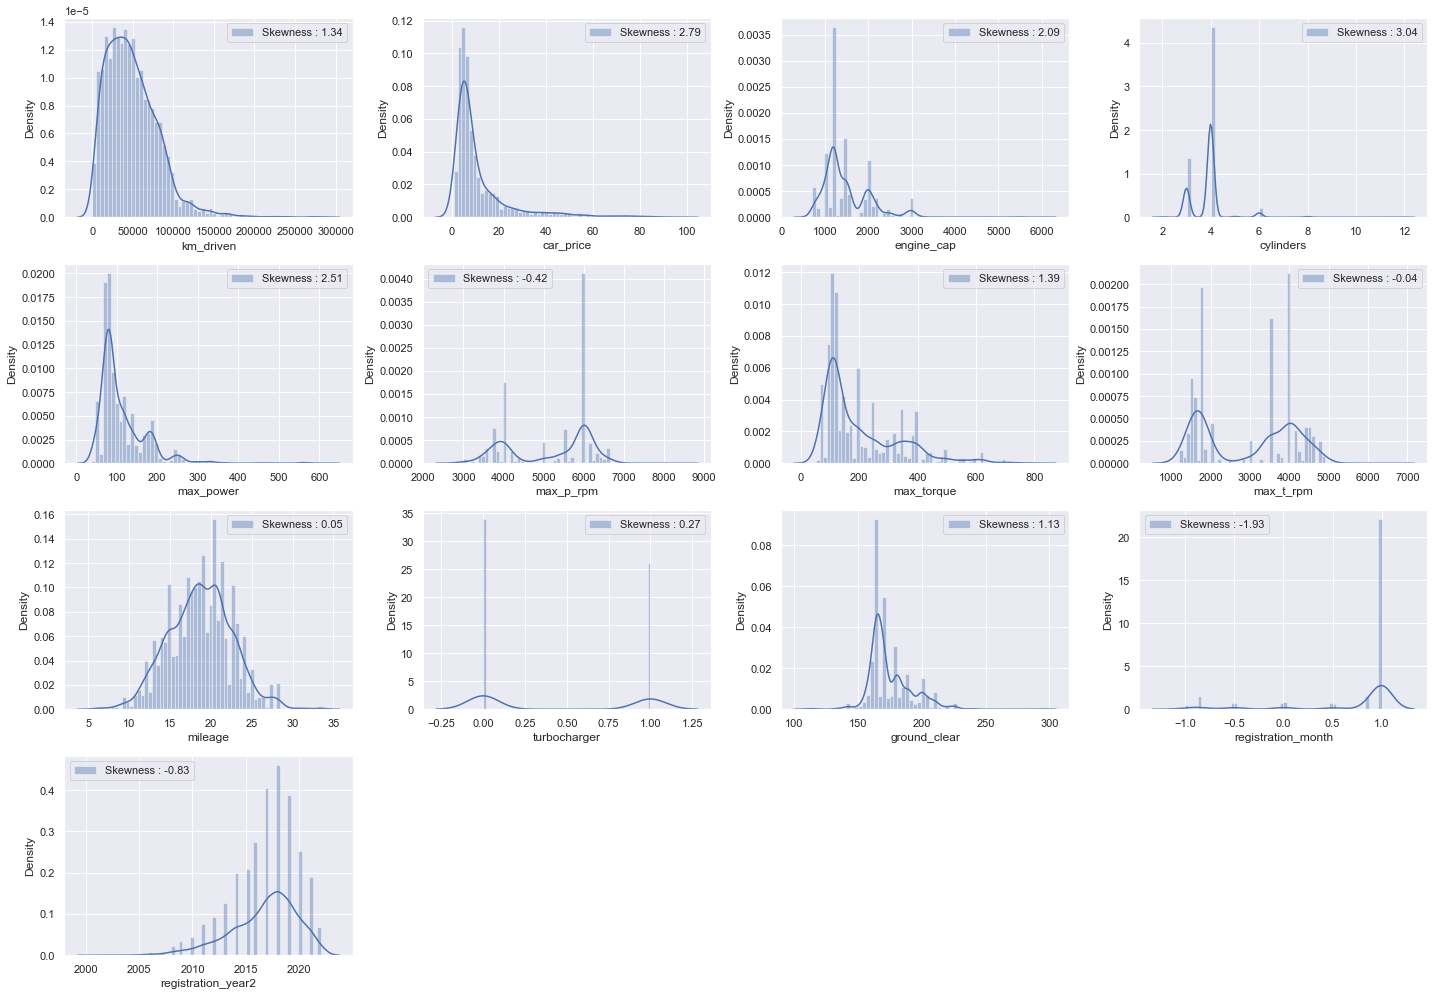

In [72]:
#distribution of numerical features.. 
i=0
plt.figure(figsize=(20,14))
for column in data4[num_cols].columns:
    plt.subplot(4,4,i+1)
    sns.distplot(data4[column], bins=60, label="Skewness : %.2f"%(data4[column].skew())).legend(loc="best")
    plt.xlabel(column,fontsize=12)
    i+=1
    
plt.tight_layout()

In [73]:
num_cols_cont = ['km_driven', 'engine_cap', 'max_power',
                 'max_p_rpm', 'max_torque', 'max_t_rpm', 'mileage', 'ground_clear']

## Skewness Checking & removing using power transformer if any

In [74]:
data4[num_cols_cont].skew()

km_driven       1.344741
engine_cap      2.086137
max_power       2.511251
max_p_rpm      -0.420203
max_torque      1.388514
max_t_rpm      -0.042245
mileage         0.050840
ground_clear    1.132854
dtype: float64

In [75]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit(data4[num_cols_cont])
x = pt.transform(data4[num_cols_cont])
x = pd.DataFrame(x, columns=data4[num_cols_cont].columns)
x.skew()

km_driven      -0.011262
engine_cap      0.019910
max_power       0.026005
max_p_rpm      -0.269917
max_torque      0.095969
max_t_rpm      -0.133975
mileage         0.004799
ground_clear   -0.104443
dtype: float64

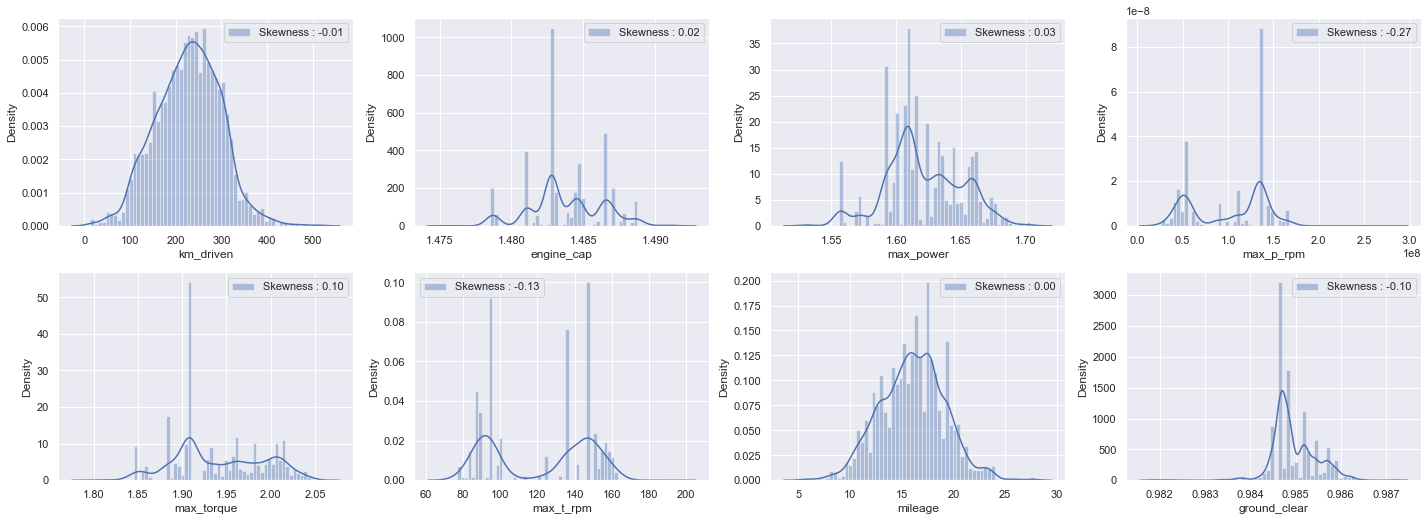

In [76]:
i=0
plt.figure(figsize=(20,14))
for column in x[num_cols_cont].columns:
    plt.subplot(4,4,i+1)
    sns.distplot(x[column], bins=60, label="Skewness : %.2f"%(x[column].skew())).legend(loc="best")
    plt.xlabel(column,fontsize=12)
    i+=1
    
plt.tight_layout()

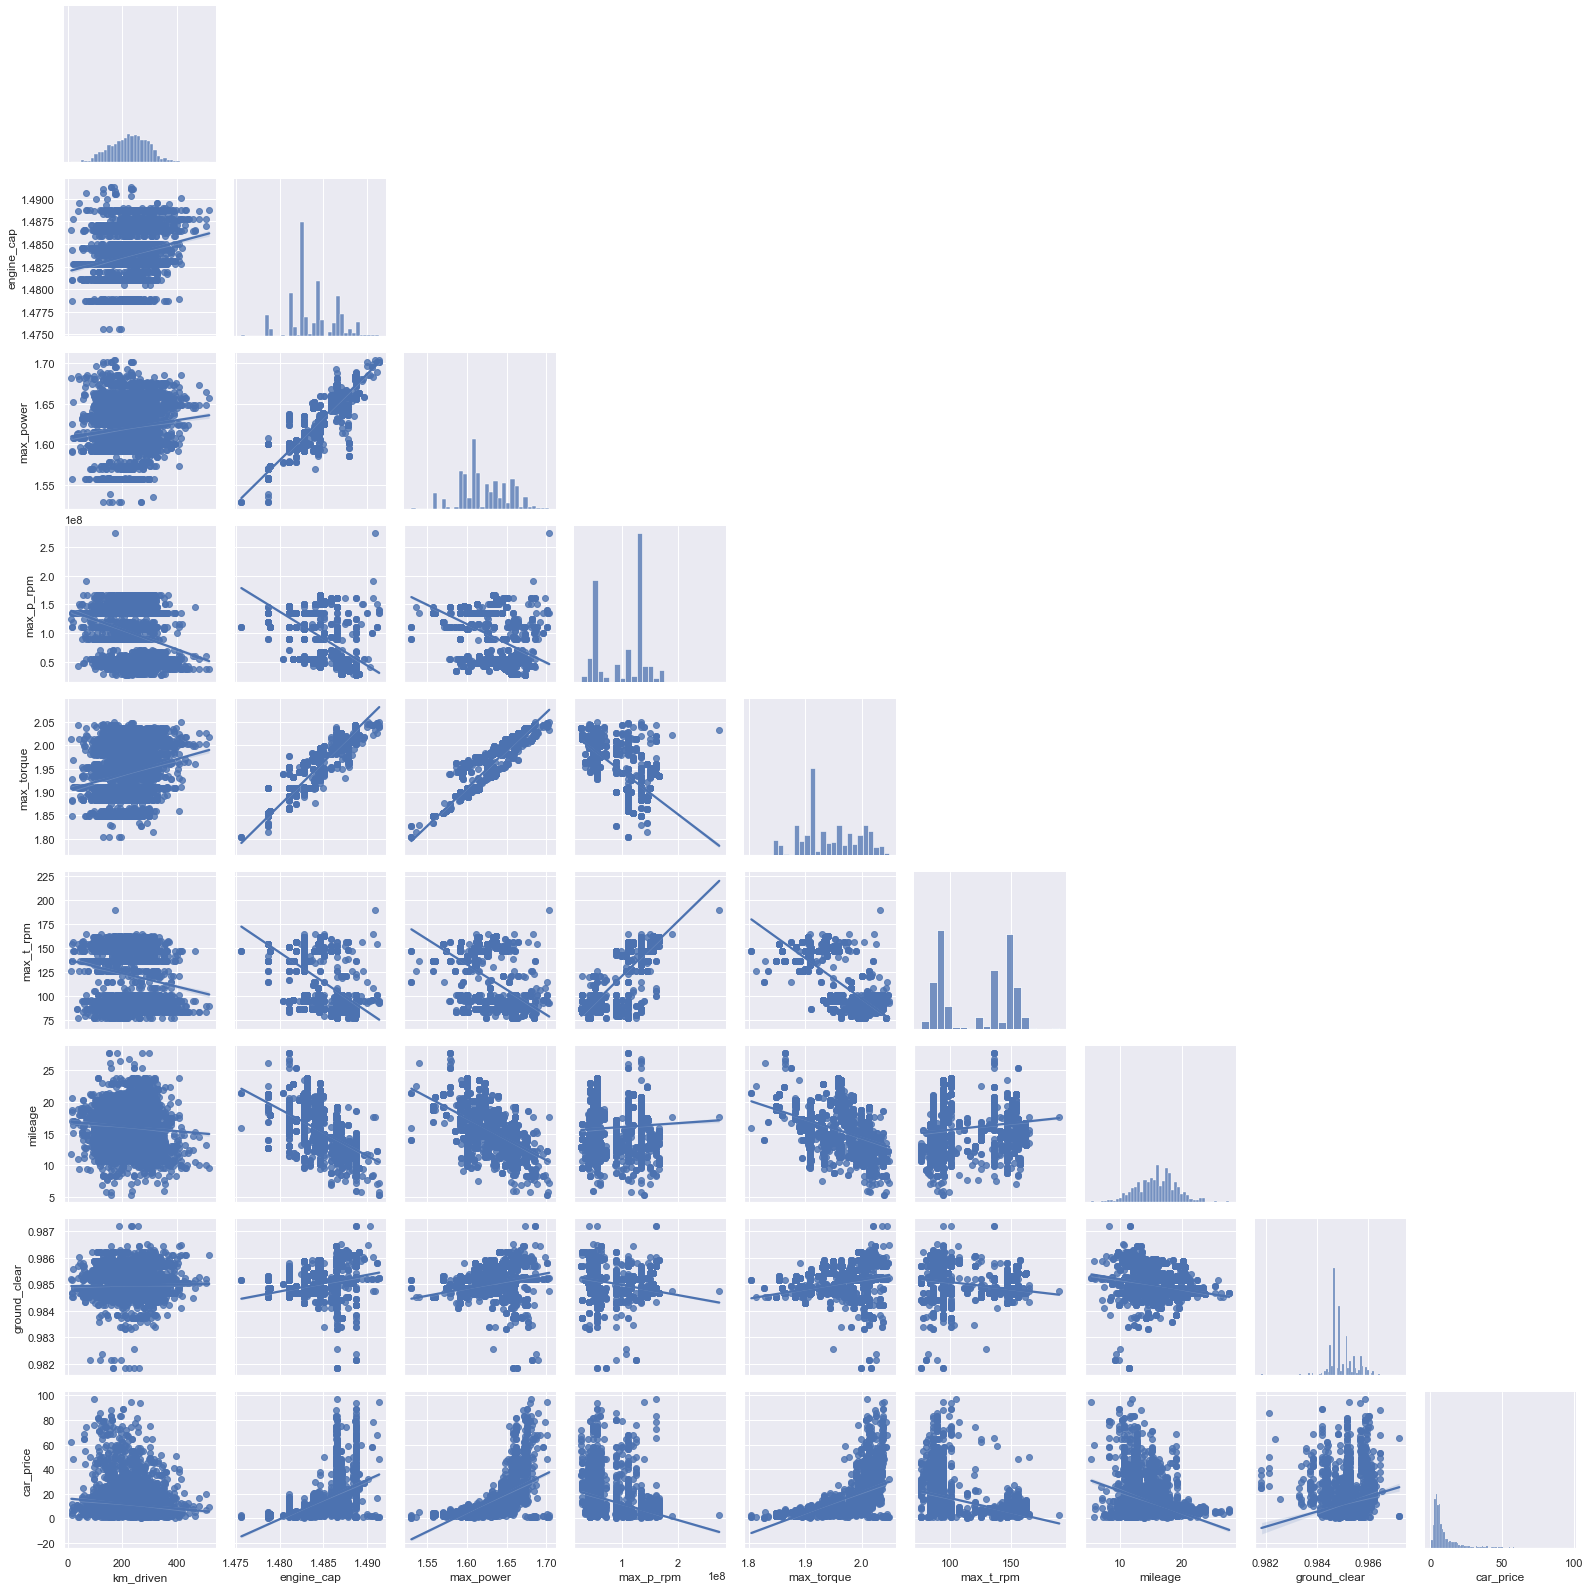

In [104]:
sns.pairplot(pd.concat([x[num_cols_cont], data4['car_price']], axis=1) , kind='reg', corner=True);

In [77]:
for col in num_cols_cont:
    data4[col]=x[col]

## Outliers Checking & removing using Z-Score or IQR method

In [78]:
# creating a function to remove outliers using standard deviation method...
def get_outliers_std(data):
    
    #empty list to store index values
    all_indices = []
    
    for column in data.columns:
        data_mean, data_std = np.mean(data[column]), np.std(data[column])
        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off

        index = np.where((data[column] < lower) | (data [column] > upper))

        all_indices.extend(index[0])
    
    set_res = set(all_indices)
    indices_to_remove = np.array(list(set_res))
#     print(indices_to_remove)
    return indices_to_remove #returns list of indices to remove outliers

# data.drop(data.index[indices_to_remove])



#  creating a function to remove outliers using inter quantile range...
def get_outliers_iqr(data):
    
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3-q1
    
    #empty list to store index values
    all_indices = []
    
    for column in data.columns:
#         data_mean, data_std = np.mean(data[column]), np.std(data[column])
#         cut_off = data_std * 3
        lower, upper = (q1[column] - (1.5*iqr[column])) , (q3[column] + (1.5*iqr[column]))

        index = np.where((data[column] < lower) | (data [column] > upper))

        all_indices.extend(index[0])
    
    set_res = set(all_indices)
    indices_to_remove = np.array(list(set_res))
#     print(indices_to_remove)
    return indices_to_remove#data.drop(data.index[indices_to_remove]) #returns the data with removed outliers

 
Total Data Loss if we remove Outliers using 3-Standard Deviation Method:  1.74 %
 


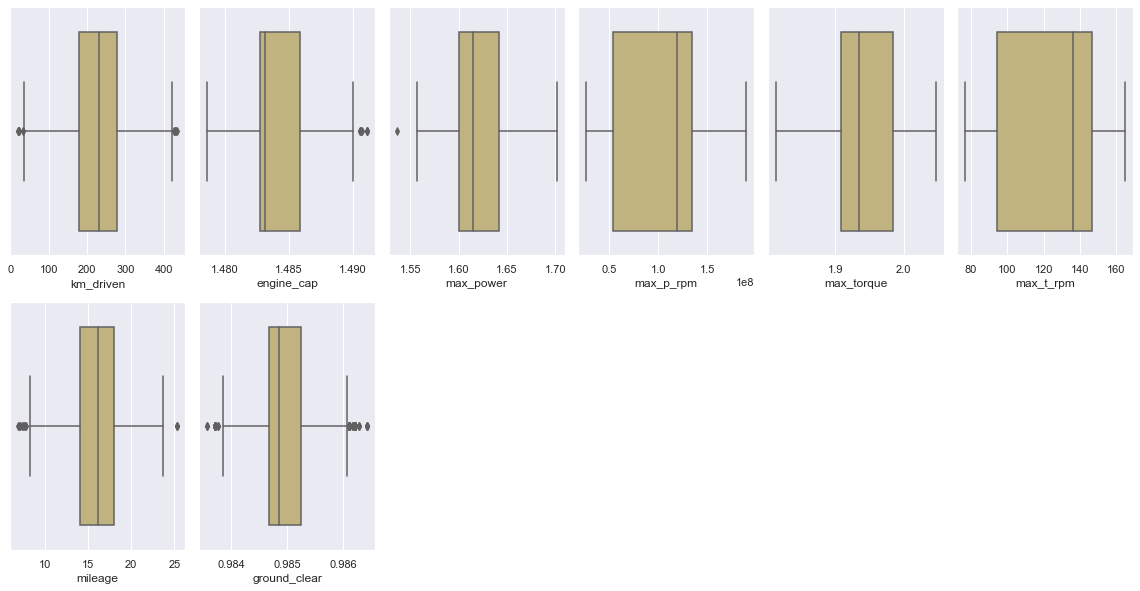

In [79]:
data_out = data4[num_cols_cont]

to_remove_std = get_outliers_std(data_out)
data_out = data_out.drop(data_out.index[to_remove_std])
data4_std = data4.drop(data4.index[to_remove_std])


print(' ')
total_data_loss = (data4.shape[0] - data4_std.shape[0])*100/data4.shape[0]
print('Total Data Loss if we remove Outliers using 3-Standard Deviation Method: ', round(total_data_loss,2),'%')
print(' ')


plt.figure(figsize=(16,12))
plotnumber=1
for col in num_cols_cont:
    if plotnumber<=len(num_cols_cont):
        ax=plt.subplot(3,6,plotnumber)
        sns.boxplot(data_out[col],color='y')
        plt.xlabel(col,fontsize=12)
    plotnumber+=1
plt.tight_layout()

 
Total Data Loss if we remove Outliers using IQR Method:  4.69 %
 


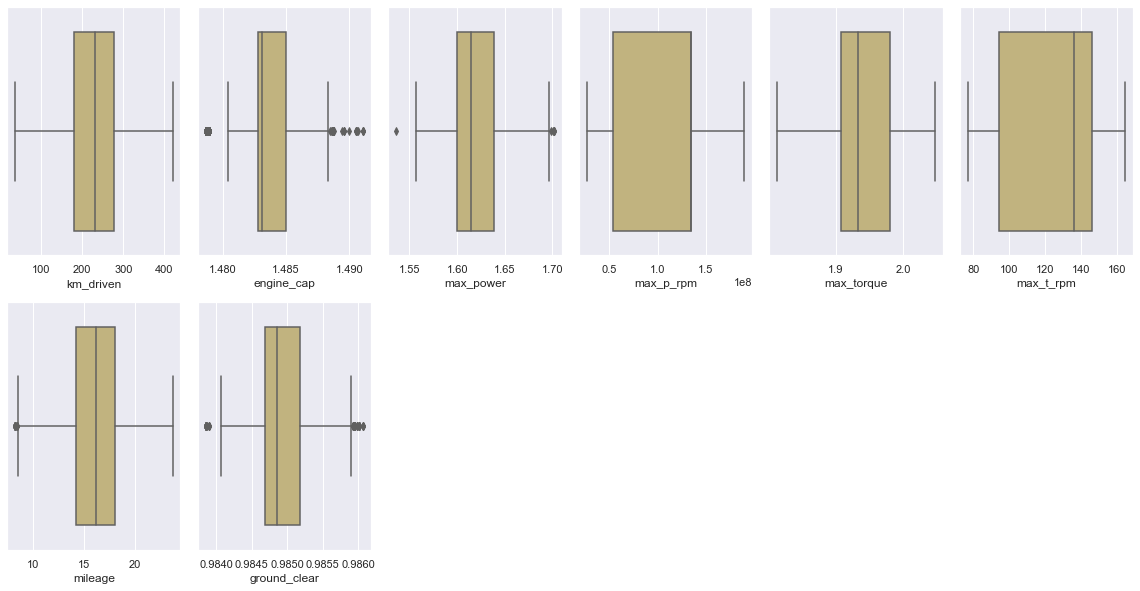

In [80]:

data_out = data4[num_cols_cont]

to_remove_iqr = get_outliers_iqr(data_out)
data_out = data_out.drop(data_out.index[to_remove_iqr])
data4_iqr = data4.drop(data4.index[to_remove_iqr])


print(' ')
total_data_loss = (data4.shape[0] - data4_iqr.shape[0])*100/data4.shape[0]
print('Total Data Loss if we remove Outliers using IQR Method: ', round(total_data_loss,2),'%')
print(' ')


plt.figure(figsize=(16,12))
plotnumber=1
for col in num_cols_cont:
    if plotnumber<=len(num_cols_cont):
        ax=plt.subplot(3,6,plotnumber)
        sns.boxplot(data_out[col],color='y')
        plt.xlabel(col,fontsize=12)
    plotnumber+=1
plt.tight_layout()

In [81]:
data5 = data4_std.reset_index(drop = True)
data5

,km_driven,car_price,engine_cap,cylinders,max_power,max_p_rpm,max_torque,max_t_rpm,mileage,turbocharger,ground_clear,registration_month,registration_year2,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Chevrolet,brand_Datsun,brand_Dehat,brand_Fiat,brand_Ford,brand_Honda,brand_Hyundai,brand_Isuzu,brand_Jaguar,brand_Jeep,brand_Kia,brand_Lamborghini,brand_Land,brand_Lexus,brand_MG,brand_MINI,brand_Mahindra,brand_Maruti,brand_Mercedes-Benz,brand_Mitsubishi,brand_Nissan,brand_Porsche,brand_Renault,brand_Skoda,brand_Ssangyong,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo,model_1-Series,model_1000 AC,model_2,model_3-Series,model_5-Series,model_6-Series,model_7-Series,model_718,model_800 AC,model_800 EX,model_800 Std,model_A-Class,model_A-Star Vxi,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_AMG,model_Accent,model_Accord,model_Alcazar,model_Alto 800,model_Alto LX,model_Alto LXi,model_Alto VXI,model_Alto VXi,model_Altroz,model_Alturas,model_Amaze,model_Ameo,model_Aspire,model_Astor,model_Aura,model_Aveo,model_B-class,model_BR-V,model_Baleno Alpha,model_Baleno Delta,model_Baleno RS,model_Baleno Sigma,model_Baleno Zeta,model_Beat,model_Beetle,model_Bolero,model_Boxster,model_Brio,model_C-Class,model_CLA,model_CR-V,model_Camry,model_Carnival,model_Cayenne,model_Celerio LXi,model_Celerio VXi,model_Celerio X,model_Celerio ZXi,model_Cherokee,model_Chevrolet,model_Ciaz Alpha,model_Ciaz Delta,model_Ciaz S,model_Ciaz Sigma,model_Ciaz VDi,model_Ciaz VDi+,model_Ciaz VXi,model_Ciaz VXi+,model_Ciaz ZDi,model_Ciaz ZDi+,model_Ciaz ZXI+,model_Ciaz ZXi,model_Ciaz Zeta,model_City,model_Civic,model_Clubman,model_Compass,model_Continental,model_Convertible,model_Cooper,model_Corolla,model_Countryman,model_Creta,model_Cruze,model_D-Max,model_DZire LXi,model_DZire VDi,model_DZire VXi,model_DZire ZDi,model_DZire ZXi,model_Duster,model_E-Class,model_ES,model_Ecosport,model_Eeco 5,model_Eeco 7,model_Elantra,model_Elite i20,model_Endeavour,model_Enjoy,model_Eon,model_Ertiga VDI,model_Ertiga VDi,model_Ertiga VXI,model_Ertiga VXi,model_Ertiga Vxi,model_Ertiga ZDI,model_Ertiga ZDi,model_Ertiga ZXI+,model_Ertiga ZXi,model_Estilo LXi,model_Etios,model_F-Pace,model_Fabia,model_Fiesta,model_Fiesta/Classic,model_Figo,model_Fluence,model_Ford,model_Fortuner,model_Freestyle,model_G-Class,model_GL-Class,model_GLA,model_GLC,model_GLE,model_GLS,model_Getz,model_Glanza,model_Gloster,model_Go,model_Grand i10,model_Gypsy King,model_Harrier,model_Hector,model_Hexa,model_Huracan,model_Hyundai,model_Ignis Alpha,model_Ignis Delta,model_Ignis Sigma,model_Ignis Zeta,model_Indica,model_Indigo,model_Innova,model_Jazz,model_Jetta,model_KUV100,model_Kicks,model_Kiger,model_Kushaq,model_Kwid,model_Laura,model_Linea,model_Lodgy,model_M-Class,model_Macan,model_Mahindra,model_Marazzo,model_Martin,model_Maruti,model_Maybach,model_Micra,model_Mobilio,model_Nano,model_Nexon,model_Octavia,model_Omni LPG,model_Optra,model_Pajero,model_Passat,model_Polo,model_Pulse,model_Punch,model_Punto,model_Q3,model_Q5,model_Q7,model_Q8,model_Quanto,model_Rapid,model_Redigo,model_Renault,model_Rexton,model_Ritz Ldi,model_Ritz Vdi,model_Ritz Vxi,model_Ritz Zdi,model_Ritz Zxi,model_Rover,model_S-Class,model_S-Cross Alpha,model_S-Cross Delta,model_S-Cross Sigma,model_S-Cross Zeta,model_S-Presso VXi,model_S5,model_S60,model_S90,model_SLC,model_SLK-Class,model_SX4 ZXi,model_Safari,model_Sail,model_Santa,model_Santro,model_Scorpio,model_Seltos,model_Sonata,model_Sonet,model_Spark,model_Sunny,model_Superb,model_Swift DZire,model_Swift Deca,model_Swift LDi,model_Swift LXi,model_Swift Lxi,model_Swift VDi,model_Swift VXi,model_Swift ZDi,model_Swift ZXi,model_TT,model_TUV300,model_Taigun,model_Tata,model_Tavera,model_Terrano,model_Thar,model_Tiago,model_Tigor,model_Tiguan,model_Triber,model_Tucson,model_Urban,model_V-Class,model_V40,model_V90,model_Vento,model_Venue,model_Verna,model_Versa DX,model_Vitara Brezza,model_Volkswagen,model_WR-V,model_Wagon R,model_X1,model_X3,model_X4,model_X5,mod

## Correlation & multicollinearity checking

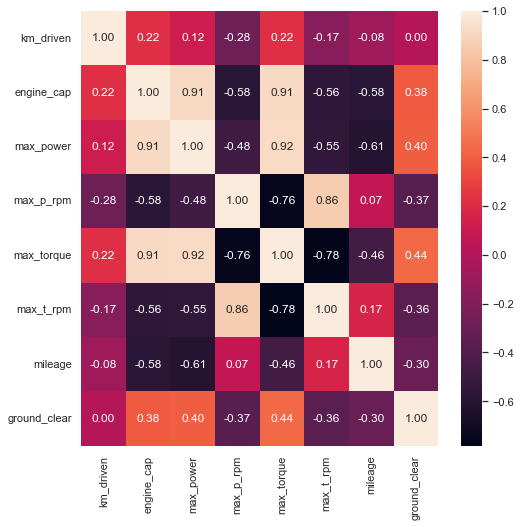

In [82]:
plt.figure(figsize=(8,8))
sns.heatmap(data5[num_cols_cont].corr(),annot=True, fmt = ".2f", annot_kws={'size':12});
plt.show()

In [83]:
x_check = data5[num_cols_cont]

In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_feat = x_check

vif = pd.DataFrame()
vif["variables"] = df_feat.columns
vif["VIF"] = [variance_inflation_factor(df_feat.values, i) for i in range(df_feat.shape[1])]
vif.sort_values(by = 'VIF', ascending = False)

,variables,VIF
1,engine_cap,2.247076e+06
7,ground_clear,1.944386e+06
2,max_power,8.427425e+04
4,max_torque,7.662584e+04
5,max_t_rpm,1.234129e+02
3,max_p_rpm,5.627371e+01
6,mileage,5.314955e+01
0,km_driven,1.426998e+01


In [85]:
df_feat = x_check.drop(columns = ['engine_cap', 'max_power', 'ground_clear', 'max_t_rpm', 'max_torque'])

vif = pd.DataFrame()
vif["variables"] = df_feat.columns
vif["VIF"] = [variance_inflation_factor(df_feat.values, i) for i in range(df_feat.shape[1])]
vif.sort_values(by = 'VIF', ascending = False)

,variables,VIF
2,mileage,13.446290
0,km_driven,8.158792
1,max_p_rpm,6.105883


In [86]:
df_feat = x_check.drop(columns = ['engine_cap', 'max_power', 'ground_clear', 'max_t_rpm', 'max_torque', 'mileage'])

vif = pd.DataFrame()
vif["variables"] = df_feat.columns
vif["VIF"] = [variance_inflation_factor(df_feat.values, i) for i in range(df_feat.shape[1])]
vif.sort_values(by = 'VIF', ascending = False)

,variables,VIF
1,max_p_rpm,3.70402
0,km_driven,3.70402


## Applying Standard Scaler

In [87]:
scaler = StandardScaler()
X=data5.drop(['car_price','engine_cap', 'max_power', 'ground_clear', 'max_t_rpm', 'max_torque', 'mileage'], axis=1)
scaler.fit(X)

Xr = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)
Xr

,km_driven,cylinders,max_p_rpm,turbocharger,registration_month,registration_year2,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,brand_Chevrolet,brand_Datsun,brand_Dehat,brand_Fiat,brand_Ford,brand_Honda,brand_Hyundai,brand_Isuzu,brand_Jaguar,brand_Jeep,brand_Kia,brand_Lamborghini,brand_Land,brand_Lexus,brand_MG,brand_MINI,brand_Mahindra,brand_Maruti,brand_Mercedes-Benz,brand_Mitsubishi,brand_Nissan,brand_Porsche,brand_Renault,brand_Skoda,brand_Ssangyong,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo,model_1-Series,model_1000 AC,model_2,model_3-Series,model_5-Series,model_6-Series,model_7-Series,model_718,model_800 AC,model_800 EX,model_800 Std,model_A-Class,model_A-Star Vxi,model_A3,model_A4,model_A5,model_A6,model_A7,model_A8,model_AMG,model_Accent,model_Accord,model_Alcazar,model_Alto 800,model_Alto LX,model_Alto LXi,model_Alto VXI,model_Alto VXi,model_Altroz,model_Alturas,model_Amaze,model_Ameo,model_Aspire,model_Astor,model_Aura,model_Aveo,model_B-class,model_BR-V,model_Baleno Alpha,model_Baleno Delta,model_Baleno RS,model_Baleno Sigma,model_Baleno Zeta,model_Beat,model_Beetle,model_Bolero,model_Boxster,model_Brio,model_C-Class,model_CLA,model_CR-V,model_Camry,model_Carnival,model_Cayenne,model_Celerio LXi,model_Celerio VXi,model_Celerio X,model_Celerio ZXi,model_Cherokee,model_Chevrolet,model_Ciaz Alpha,model_Ciaz Delta,model_Ciaz S,model_Ciaz Sigma,model_Ciaz VDi,model_Ciaz VDi+,model_Ciaz VXi,model_Ciaz VXi+,model_Ciaz ZDi,model_Ciaz ZDi+,model_Ciaz ZXI+,model_Ciaz ZXi,model_Ciaz Zeta,model_City,model_Civic,model_Clubman,model_Compass,model_Continental,model_Convertible,model_Cooper,model_Corolla,model_Countryman,model_Creta,model_Cruze,model_D-Max,model_DZire LXi,model_DZire VDi,model_DZire VXi,model_DZire ZDi,model_DZire ZXi,model_Duster,model_E-Class,model_ES,model_Ecosport,model_Eeco 5,model_Eeco 7,model_Elantra,model_Elite i20,model_Endeavour,model_Enjoy,model_Eon,model_Ertiga VDI,model_Ertiga VDi,model_Ertiga VXI,model_Ertiga VXi,model_Ertiga Vxi,model_Ertiga ZDI,model_Ertiga ZDi,model_Ertiga ZXI+,model_Ertiga ZXi,model_Estilo LXi,model_Etios,model_F-Pace,model_Fabia,model_Fiesta,model_Fiesta/Classic,model_Figo,model_Fluence,model_Ford,model_Fortuner,model_Freestyle,model_G-Class,model_GL-Class,model_GLA,model_GLC,model_GLE,model_GLS,model_Getz,model_Glanza,model_Gloster,model_Go,model_Grand i10,model_Gypsy King,model_Harrier,model_Hector,model_Hexa,model_Huracan,model_Hyundai,model_Ignis Alpha,model_Ignis Delta,model_Ignis Sigma,model_Ignis Zeta,model_Indica,model_Indigo,model_Innova,model_Jazz,model_Jetta,model_KUV100,model_Kicks,model_Kiger,model_Kushaq,model_Kwid,model_Laura,model_Linea,model_Lodgy,model_M-Class,model_Macan,model_Mahindra,model_Marazzo,model_Martin,model_Maruti,model_Maybach,model_Micra,model_Mobilio,model_Nano,model_Nexon,model_Octavia,model_Omni LPG,model_Optra,model_Pajero,model_Passat,model_Polo,model_Pulse,model_Punch,model_Punto,model_Q3,model_Q5,model_Q7,model_Q8,model_Quanto,model_Rapid,model_Redigo,model_Renault,model_Rexton,model_Ritz Ldi,model_Ritz Vdi,model_Ritz Vxi,model_Ritz Zdi,model_Ritz Zxi,model_Rover,model_S-Class,model_S-Cross Alpha,model_S-Cross Delta,model_S-Cross Sigma,model_S-Cross Zeta,model_S-Presso VXi,model_S5,model_S60,model_S90,model_SLC,model_SLK-Class,model_SX4 ZXi,model_Safari,model_Sail,model_Santa,model_Santro,model_Scorpio,model_Seltos,model_Sonata,model_Sonet,model_Spark,model_Sunny,model_Superb,model_Swift DZire,model_Swift Deca,model_Swift LDi,model_Swift LXi,model_Swift Lxi,model_Swift VDi,model_Swift VXi,model_Swift ZDi,model_Swift ZXi,model_TT,model_TUV300,model_Taigun,model_Tata,model_Tavera,model_Terrano,model_Thar,model_Tiago,model_Tigor,model_Tiguan,model_Triber,model_Tucson,model_Urban,model_V-Class,model_V40,model_V90,model_Vento,model_Venue,model_Verna,model_Versa DX,model_Vitara Brezza,model_Volkswagen,model_WR-V,model_Wagon R,model_X1,model_X3,model_X4,model_X5,model_X6,model_XC40,model_XC60,model_XC90,model_XE,model_XF,model_XJ,model_X

In [124]:
y_reg = data5['car_price']*100000

# Regression model Selection

In [126]:
lr2 = LinearRegression()
ls2 = Lasso()
rd2 = Ridge()
rfr2 = RandomForestRegressor()
abr2 = AdaBoostRegressor()
gbr2 = GradientBoostingRegressor()
dtr2 = DecisionTreeRegressor()
svr2 = SVR()
knr2 = KNeighborsRegressor()
xgb2 = XGBRegressor()

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
 
 
Linear Regression Model
 
for Linear Regression model, Best Random_state number for splitting the data is:  23
 
===scores for training set===
r2 score for training set 82.77270819724068
MAE for training set:  268173.41588156123
MSE for training set:  296526112012.4899
SMSE for training set:  544542.1122488966
 
===scores for testing set===
r2 score for testing set :  -1.5929994232684135e+28
MAE for testing set:  1.6975819165566536e+18
MSE for testing set:  2.9104906706931315e+38
SMSE for testing set:  1.7060160229883924e+19
 
 


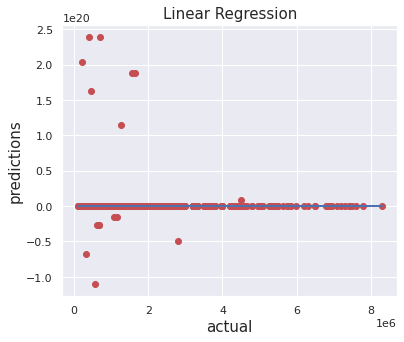

 
Cross Validation score at best cv=4 is : -147360467222566238713385320448.00%
 
 
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
 
 
Lasso Model
 
for Lasso model, Best Random_state number for splitting the data is:  41
 
===scores for training set===
r2 score for training set 82.56911584657456
MAE for training set:  268741.40398352966
MSE for training set:  307621123136.8767
SMSE for training set:  554636.0276225092
 
===scores for testing set===
r2 score for testing set :  82.78930542921583
MAE for testing set:  282237.0809881918
MSE for testing set:  292236980886.93506
SMSE for testing set:  540589.4753756635
 
 


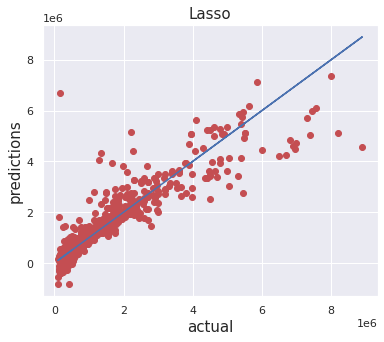

 
Cross Validation score at best cv=5 is : 66.77%
 
 
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
 
 
Ridge Model
 
for Ridge model, Best Random_state number for splitting the data is:  12
 
===scores for training set===
r2 score for training set 82.08708601236874
MAE for training set:  275777.85852652
MSE for training set:  323292977368.8072
SMSE for training set:  568588.5835723465
 
===scores for testing set===
r2 score for testing set :  82.33464932722339
MAE for testing set:  295787.21239287365
MSE for testing set:  278693423088.3928
SMSE for testing set:  527914.2194413717
 
 


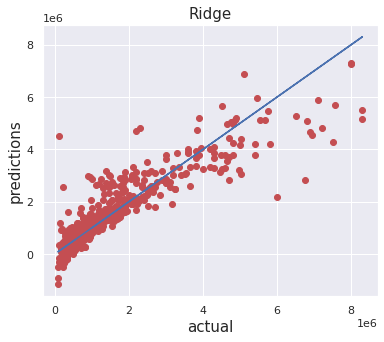

 
Cross Validation score at best cv=5 is : 66.33%
 
 
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
 
 
Ada-Boost Regressor Model
 
for Ada-Boost Regressor model, Best Random_state number for splitting the data is:  21
 
===scores for training set===
r2 score for training set 58.292473880962206
MAE for training set:  602212.9274714236
MSE for training set:  723733341759.6976
SMSE for training set:  850725.1858030874
 
===scores for testing set===
r2 score for testing set :  55.75470777877405
MAE for testing set:  611242.578204852
MSE for testing set:  790518757402.2037
SMSE for testing set:  889111.217678758
 
 


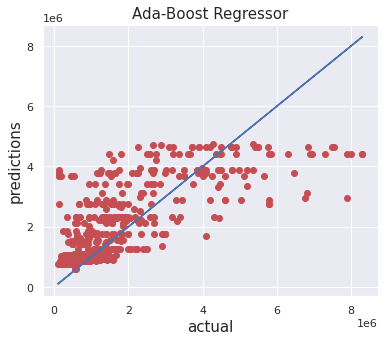

 
Cross Validation score at best cv=4 is : 49.77%
 
 
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
 
 
Gradient Boosting Regressor Model
 
for Gradient Boosting Regressor model, Best Random_state number for splitting the data is:  41
 
===scores for training set===
r2 score for training set 88.35567883415958
MAE for training set:  235830.28634211895
MSE for training set:  205499567530.4518
SMSE for training set:  453320.60126410733
 
===scores for testing set===
r2 score for testing set :  87.97431154600692
MAE for testing set:  234575.15908264587
MSE for testing set:  204195761677.60016
SMSE for testing set:  451880.2514799691
 
 


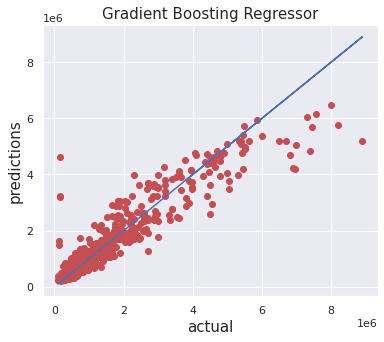

 
Cross Validation score at best cv=6 is : 77.69%
 
 
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
 
 
Decision Tree Regressor Model
 
for Decision Tree Regressor model, Best Random_state number for splitting the data is:  49
 
===scores for training set===
r2 score for training set 99.99996648946595
MAE for training set:  30.28263795423959
MSE for training set:  594212.6514131916
SMSE for training set:  770.851899792166
 
===scores for testing set===
r2 score for testing set :  83.80909179548422
MAE for testing set:  187932.89606458123
MSE for testing set:  270607316094.85367
SMSE for testing set:  520199.30420450744
 
 


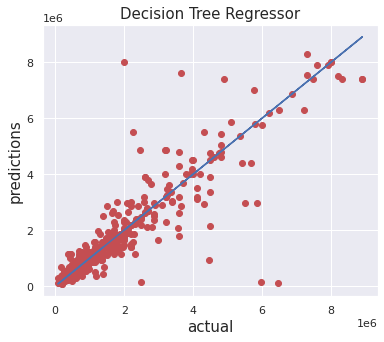

 
Cross Validation score at best cv=6 is : 68.34%
 
 
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
 
 
Support Vector Machine Model
 
for Support Vector Machine model, Best Random_state number for splitting the data is:  46
 
===scores for training set===
r2 score for training set -14.189385656201958
MAE for training set:  720520.0978146691
MSE for training set:  1993957488487.7341
SMSE for training set:  1412075.5958827892
 
===scores for testing set===
r2 score for testing set :  -14.197444884309164
MAE for testing set:  717492.263594514
MSE for testing set:  2003067804088.5312
SMSE for testing set:  1415297.7792989472
 
 


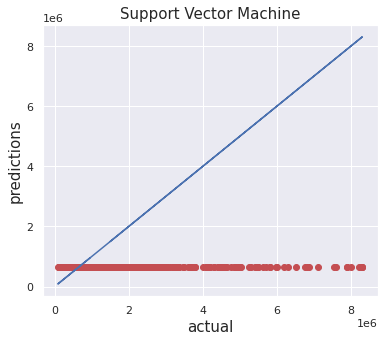

 
Cross Validation score at best cv=4 is : -15.30%
 
 
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
 
 
KNeighbors Regressor Model
 
for KNeighbors Regressor model, Best Random_state number for splitting the data is:  41
 
===scores for training set===
r2 score for training set 78.76205656235287
MAE for training set:  253567.2947510094
MSE for training set:  374808297496.63525
SMSE for training set:  612215.8912480427
 
===scores for testing set===
r2 score for testing set :  78.91427870813263
MAE for testing set:  283946.316851665
MSE for testing set:  358034796609.48535
SMSE for testing set:  598360.0894189763
 
 


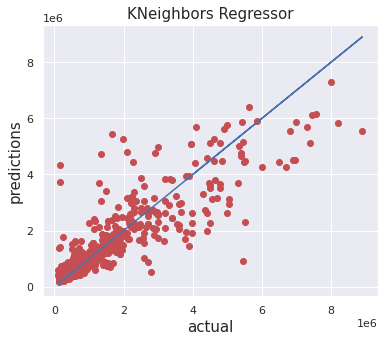

 
Cross Validation score at best cv=10 is : 66.87%
 
 
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
 
 
XGB Regressor Model
 
for XGB Regressor model, Best Random_state number for splitting the data is:  41
 
===scores for training set===
r2 score for training set 99.01298585274289
MAE for training set:  78648.05620557495
MSE for training set:  17418875477.498596
SMSE for training set:  131980.5875024755
 
===scores for testing set===
r2 score for testing set :  93.12998632527541
MAE for testing set:  150430.38363237891
MSE for testing set:  116652587534.82108
SMSE for testing set:  341544.41517146945
 
 


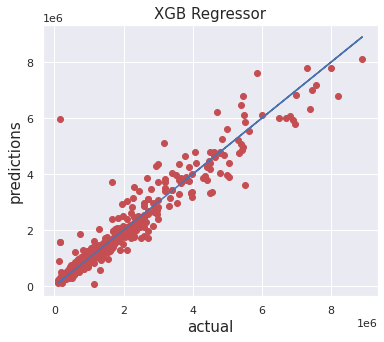

 
Cross Validation score at best cv=10 is : 82.38%
 
 
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
 
 
Random Forest Regressor Model
 
for Random Forest Regressor model, Best Random_state number for splitting the data is:  49
 
===scores for training set===
r2 score for training set 97.53796944704499
MAE for training set:  73990.5730308274
MSE for training set:  43657009475.655174
SMSE for training set:  208942.5985184811
 
===scores for testing set===
r2 score for testing set :  91.54838569434187
MAE for testing set:  156619.21039354187
MSE for testing set:  141256354185.56296
SMSE for testing set:  375840.8628469807
 
 


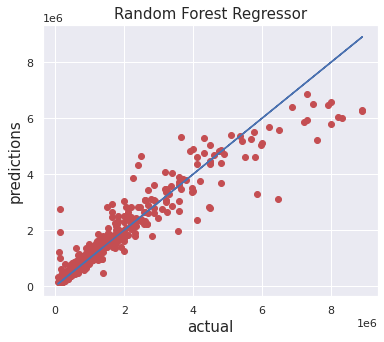

 
Cross Validation score at best cv=8 is : 83.83%
 
 


,Model,Best_Random_State,Train_r2_Score,Test_r2_Score,Train_MAE,Train_MSE,Train_SMSE,Test_MAE,Test_MSE,Test_SMSE,Best_CV_Fold,Cross_Val_Score
Sr. No.,,,,,,,,,,,,
9,XGB Regressor,41,99.01,9.313000e+01,78648.06,1.741888e+10,131980.59,1.504304e+05,1.166526e+11,3.415444e+05,10,8.200000e+01
10,Random Forest Regressor,49,97.54,9.155000e+01,73990.57,4.365701e+10,208942.60,1.566192e+05,1.412564e+11,3.758409e+05,8,8.400000e+01
6,Decision Tree Regressor,49,100.00,8.381000e+01,30.28,5.942127e+05,770.85,1.879329e+05,2.706073e+11,5.201993e+05,6,6.800000e+01
5,Gradient Boosting Regressor,41,88.36,8.797000e+01,235830.29,2.054996e+11,453320.60,2.345752e+05,2.041958e+11,4.518802e+05,6,7.800000e+01
2,Lasso,41,82.57,8.279000e+01,268741.40,3.076211e+11,554636.03,2.822371e+05,2.922370e+11,5.405895e+05,5,6.700000e+01
8,KNeighbors Regressor,41,78.76,7.891000e+01,253567.29,3.748083e+11,612215.89,2.839463e+05,3.580348e+11,5.983601e+05,10,6.700000e+01
3,Ridge,12,82.09,8.233000e+01,275777.86,3.232930e+11,568588.58,2.957872e+05,2.786934e+11,5.279142e+05,5,6.600000e+01
4,Ada-Boost Regressor,21,58.29,5.575000e+01,602212.93,7.237333e+11,850725.19,6.112426e+05,7.905188e+11,8.891112e+05,4,5.000000e+01
7,Support Vector Machine,46,-14.19,-1.420000e+01,720520.10,1.993957e+12,1412075.60,7.174923e+05,2.003068e+12,1.415298e+06,4,-1.500000e+01


In [127]:
algo = [] #list to save ML algorithm name
rs = []
cv_fold = []
#lists to store evaluation metrics data for train set
train_r2score = [] 
train_mae = []
train_mse = []
train_srmse = []


#lists to store evaluation metrics data for test set
test_r2score = []
test_mae = []
test_mse = []
test_srmse = []

crossvalscore = []
score_diff = []


models = [lr2, ls2, rd2, abr2, gbr2, dtr2,svr2, knr2, xgb2, rfr2]
models_name = ['Linear Regression', 'Lasso', 'Ridge',
               'Ada-Boost Regressor', 'Gradient Boosting Regressor',
               'Decision Tree Regressor','Support Vector Machine', 'KNeighbors Regressor', 'XGB Regressor', 'Random Forest Regressor']
dummy_count = 0 #dummy variable for count purpose
for model in models:
    diff = []
    randomstate = []
    for i in range(0, 100):  ### loop to find best random state for splitting
        x_train, x_test, y_train, y_test = train_test_split(Xr, y_reg, test_size = 0.25, random_state = i)
        model.fit(x_train, y_train)
        pred_train = model.predict(x_train)
        pred_test = model.predict(x_test)
        diff.append(abs(r2_score(y_train, pred_train) - r2_score(y_test, pred_test)))
        randomstate.append(i)
        
    best_i = randomstate[diff.index(min(diff))]
    rs.append(best_i)
    
    ### splitting the train7 set with best random state
    x_train, x_test, y_train, y_test = train_test_split(Xr, y_reg, random_state=best_i, test_size=.25)
    
    
    ### straining the model
    model.fit(x_train, y_train)
    algo.append(models_name[dummy_count])
    pred_test = model.predict(x_test)
    pred_train = model.predict(x_train)
    
     ### storing metrics into respective lists
    train_r2score.append(round(r2_score(y_train, pred_train)*100,2))
    train_mae.append(round(mean_absolute_error(y_train, pred_train),2))
    train_mse.append(round(mean_squared_error(y_train, pred_train),2))
    train_srmse.append(round(np.sqrt(mean_squared_error(y_train, pred_train)),2))
    
    
    test_r2score.append(round(r2_score(y_test, pred_test)*100,2))
    test_mae.append(round(mean_absolute_error(y_test, pred_test),2))
    test_mse.append(round(mean_squared_error(y_test, pred_test),2))
    test_srmse.append(round(float(np.sqrt(mean_squared_error(y_test, pred_test))),2))
    
    
    ##showing the results in output
    print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
    print(' ')
    print(' ')
    print(models_name[dummy_count] + ' Model')
    print(' ')
    print('for '+ models_name[dummy_count] + ' model, Best Random_state number for splitting the data is: ', best_i)
    print(' ')
    print('===scores for training set===')
    print('r2 score for training set', r2_score(y_train, pred_train)*100)
    print('MAE for training set: ', mean_absolute_error(y_train, pred_train))
    print('MSE for training set: ', mean_squared_error(y_train, pred_train))
    print('SMSE for training set: ', np.sqrt(mean_squared_error(y_train, pred_train)))
    print(' ')
    print('===scores for testing set===')
    print('r2 score for testing set : ', r2_score(y_test, pred_test)*100)
    print('MAE for testing set: ', mean_absolute_error(y_test, pred_test))
    print('MSE for testing set: ', mean_squared_error(y_test, pred_test))
    print('SMSE for testing set: ', np.sqrt(mean_squared_error(y_test, pred_test)))
    print(' ')
    print(' ')
    
    ##plotting the graph with bestfit line, actual & predicted values
    plt.figure(figsize = (6,5))
    plt.scatter(x = y_test, y=pred_test, color = 'r')
    plt.plot(y_test, y_test, color = 'b')
    plt.xlabel('actual', fontsize = 15)
    plt.ylabel('predictions', fontsize = 15)
    plt.title(models_name[dummy_count], fontsize = 15)
    plt.show()
    
    print(' ')
    
    test_accuracy = r2_score(y_test, pred_test)
    cv_diff = []
    best_cv = []
    
    ### loop to find best CV fold value
    for j in range(4,13):
        cv_score = cross_val_score(model, Xr, y_reg, cv = j)
        cv_mean = cv_score.mean()
        cv_diff.append(abs(cv_mean - test_accuracy))
        best_cv.append(j)
    
    
    ### printing CV Score based on best CV fold value
    k_f = best_cv[cv_diff.index(min(cv_diff))]
    cv_fold.append(k_f)
    cv_score = cross_val_score(model, Xr, y_reg, cv=k_f).mean()
    crossvalscore.append(round(cv_score,2)*100)
    score_diff.append(abs(round(cv_score - test_accuracy,2)))
    print(f"Cross Validation score at best cv={k_f} is : {cv_score*100:.2f}%")          
    dummy_count+=1
    print(' ')
    print(' ')
#     print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
    

### dataframe to make list of all the ML algorithms & their evaluation metrics
table = pd.DataFrame(list(zip(algo, rs, train_r2score, test_r2score, train_mae, train_mse,
                              train_srmse, test_mae, test_mse, test_srmse, cv_fold, crossvalscore)),
                              columns =['Model', 'Best_Random_State', 'Train_r2_Score', 'Test_r2_Score', 'Train_MAE','Train_MSE',
                                       'Train_SMSE', 'Test_MAE', 'Test_MSE', 'Test_SMSE', 'Best_CV_Fold', 'Cross_Val_Score'],
                              index=pd.RangeIndex(start=1, stop=(len(algo)+1), name='Sr. No.'))


### display dataframe & sort based on TEST MAE score.
table.sort_values(by=['Test_MAE', 'Test_r2_Score', 'Cross_Val_Score', 'Test_SMSE', 'Test_MSE' ])

### Observation
We will select Random Forest Regressor model as it has,

- minimum MAE value on test set & highest cross val score.
- minimum difference between Cross_Val_Score & test score.
- train score & test score are almost similar.

# Hyper paramter tuning using GridSearchCV

In [128]:
x_train, x_test, y_train, y_test = train_test_split(Xr, y_reg, test_size = 0.25, random_state = 49)

In [129]:
param_grid_rfr2 = {'n_estimators': [100,200, 300, 400, 500],
                  'max_depth':[None,2,3,5],
                  'min_samples_split' : [2, 3, 4, 5]
                 }

In [130]:
rfr_grid2 = GridSearchCV(estimator = rfr2,
                       param_grid = param_grid_rfr2,
                       verbose = 2,
                       scoring = 'r2')

In [131]:
rfr_grid2.fit(x_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   6.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   6.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   5.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   6.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   5.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   8.9s
[CV] END max_depth=None, 

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 2, 3, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='r2', verbose=2)

In [132]:
rfr_grid2.best_params_

{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 100}

In [133]:
rfr_grid2.best_score_

0.8259549744878397

In [134]:
rfr_tune_final2 = RandomForestRegressor(max_depth=None,
                                       min_samples_split= 3,
                                       n_estimators=100)

In [135]:
rfr_tune_final2.fit(x_train,y_train)
y_pred=rfr_tune_final2.predict(x_test)

In [136]:
print('r2 score for testing set : ', r2_score(y_test, y_pred))
print('MAE for testing set: ', mean_absolute_error(y_test, y_pred))
print('MSE for testing set: ', mean_squared_error(y_test, y_pred))
print('SMSE for testing set: ', np.sqrt(mean_squared_error(y_test, y_pred)))

r2 score for testing set :  0.915522305863776
MAE for testing set:  158208.09945061107
MSE for testing set:  141192092446.7325
SMSE for testing set:  375755.36249897024


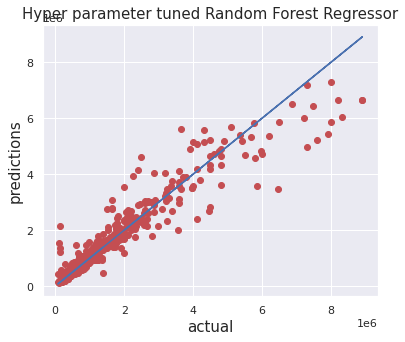

In [137]:
##plotting the graph with bestfit line, actual & predicted values
plt.figure(figsize = (6,5))
plt.scatter(x =y_test, y=y_pred, color = 'r')
plt.plot(y_test, y_test, color = 'b')
plt.xlabel('actual', fontsize = 15)
plt.ylabel('predictions', fontsize = 15)
plt.title('Hyper parameter tuned Random Forest Regressor', fontsize = 15)
plt.show()

In [138]:
cv_score = cross_val_score(rfr_tune_final2, Xr, y_reg, cv=8).mean()
print(f"Cross Validation score at best cv=8 is : {cv_score*100:.2f}%")

Cross Validation score at best cv=8 is : 83.52%


# Model Saving & Predicting on the test set

In [139]:
filename='used_car_price_prediction2.pkl'
pickle.dump(rfr_tune_final2,open(filename,'wb'))

In [140]:
model =pickle.load(open('used_car_price_prediction2.pkl','rb'))
pred =model.predict(x_test)
result = pd.DataFrame(list(zip(y_test, pred)), columns = ['Actual', 'Predicted'])
result

,Actual,Predicted
0,1399000.0,4.871230e+05
1,575000.0,5.845045e+05
2,699000.0,7.400257e+05
3,365000.0,4.804555e+05
4,680000.0,6.676663e+05
...,...,...
986,459000.0,4.565913e+05
987,1120000.0,9.557202e+05
988,525000.0,5.530595e+05
989,3580000.0,3.590954e+06
